## 1. Load EBSD data

In [1]:
%matplotlib inline

# from diffpy.structure import Atom, Lattice, Structure
import matplotlib.pyplot as plt
import numpy as np

from orix import io, plot
from orix.crystal_map import Phase
# from orix.sampling import sample_S2
from orix.vector import Miller, Vector3d
# from orix.crystal_map import CrystalMap, Phase, PhaseList
# from orix.quaternion import Orientation, Rotation, symmetry
from orix.vector import Vector3d
import kikuchipy as kp
import os
from tqdm import tqdm
from visualize_grid import read_data, set_ROI, set_component
from data_processing import get_eds_average, coord_xmap_dict, get_components
from cNMF import run_cNMF, run_cNMF_mixeds, _plot_cnmf, normalize_sum, detect_anomalies_cnmf, plot_weight_map_cnmf
from PCA import run_PCA, _plot_pca, detect_anomalies_pca, plot_weight_map_pca, plot_explained_variance
from cluster_analysis import gmm_clustering, plot_cluster_heatmap, plot_intra_cluster_variation_map, calculate_cluster_metrics, plot_gmm_clusters, clustering_accuracy
from grid_search_component import optimize_paired_components, visualize_results
# from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

plt.rcParams.update({"figure.figsize": (7, 7), "font.size": 15})
w, h = plt.rcParams["figure.figsize"]
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
# data_path = "EBSD_scan"
# data_save = "save_map/"

data_path = "../EBSD_scan"

In [3]:
fname_ang = data_path + "/Scan3_cropped.ang"
xmap = io.load(fname_ang)                                                                               

c:\Users\Angelamer\anaconda3\envs\kikuchi_cnmf\Lib\site-packages\orix\io\plugins\ang.py:285: UserWarning: Number of columns, 20, in the file is not equal to the expected number of columns, [14, 10], for the 
assumed vendor 'tsl'. Will therefore assume the following columns: euler1, euler2, euler3, x, y, unknown1, unknown2, phase_id, unknown3, unknown4, etc.
  warnings.warn(


In [4]:
xmap
# eu1, eu2, eu3, x, y, iq, ci, phase_id, sem, Fit, bs, cs, ts, Oxygen, Mg, Al, Si, Ti, Mn, Fe  = np.loadtxt(fname_ang, unpack=True)

Phase   Orientations   Name  Space group  Point group  Proper point group       Color
    1       1 (0.0%)  Fe3O4         None          432                 432   tab:green
    2   1595 (62.7%)    FeO         None          432                 432  tab:orange
    3    946 (37.2%)     Fe         None          432                 432    tab:blue
Properties: unknown1, unknown2, unknown3, unknown4, unknown5, unknown6, unknown7, unknown8, unknown9, unknown10, unknown11, unknown12, unknown13, unknown14
Scan unit: um

In [5]:
edax_binary_path = data_path + "/Scan3_cropped.up1"

s_edax = kp.load(edax_binary_path)
s_edax

<EBSD, title: Scan3_cropped, dimensions: (62, 41|239, 239)>

### 1.1 Phase map/ IQ/ IPF/ CI MAP

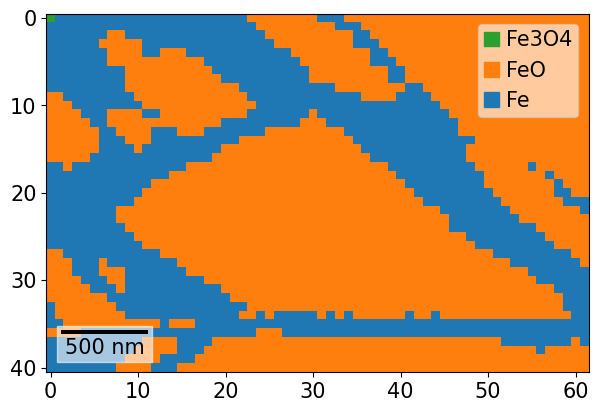

In [6]:
# phase map
xmap.plot()

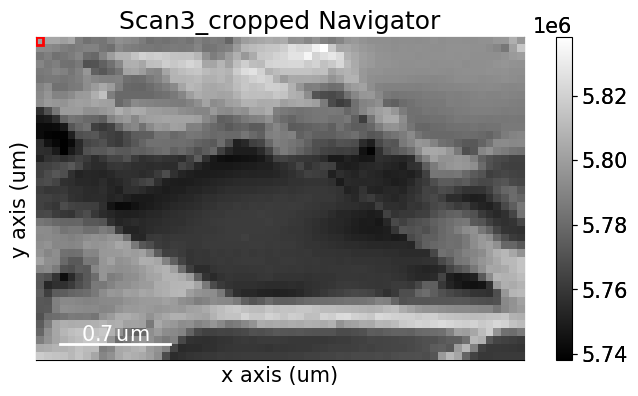

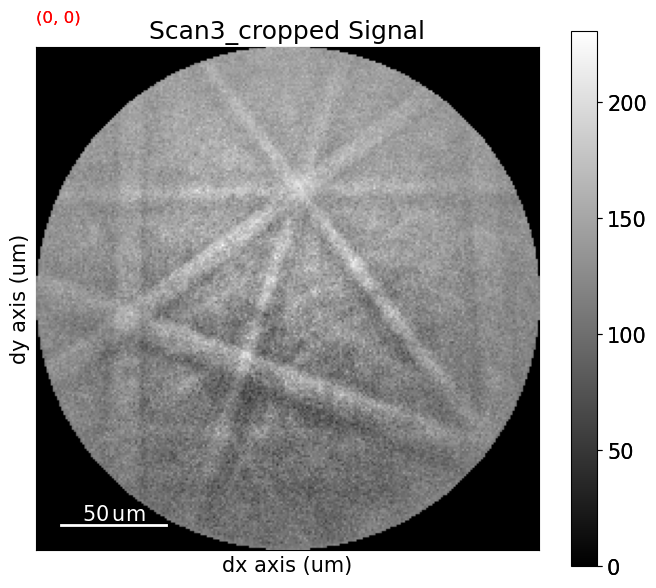

In [43]:
# Image quality map and kikuchi pattern

s_edax.plot()

In [6]:
# set the space group number
# the crystal structure of iron would be changed based on the temperature and pressure
# α-Fe (Ferrite): Body-Centered Cubic (BCC)  Im-3m  (229); γ-Fe (Austenite): Face-Centered Cubic (FCC)  Fm-3m(225); δ-Fe; ε-Fe
xmap.phases[1].space_group = 227
xmap.phases[2].space_group = 225
xmap.phases[3].space_group = 229
xmap.phases

Id   Name  Space group  Point group  Proper point group       Color
 1  Fe3O4        Fd-3m         m-3m                 432   tab:green
 2    FeO        Fm-3m         m-3m                 432  tab:orange
 3     Fe        Im-3m         m-3m                 432    tab:blue

In [7]:
# xmap parameters: IQ, CI, sem, fit, bs, cs, ts, oxygen, Mg, Al, Si, Ti, Mn, Fe
xmap.prop


# xmap.prop["iq"] = xmap.prop.pop("unknown1")
# xmap.prop["ci"] = xmap.prop.pop("unknown2")
# xmap.prop["sem"] = xmap.prop.pop("unknown3")
# xmap.prop["fit"] = xmap.prop.pop("unknown4")
# xmap.prop["bs"] = xmap.prop.pop("unknown5")
# xmap.prop["cs"] = xmap.prop.pop("unknown6")
# xmap.prop["ts"] = xmap.prop.pop("unknown7")
# xmap.prop["oxygen"] = xmap.prop.pop("unknown8")
# xmap.prop["Mg"] = xmap.prop.pop("unknown9")
# xmap.prop["Al"] = xmap.prop.pop("unknown10")
# xmap.prop["Si"] = xmap.prop.pop("unknown11")
# xmap.prop["Ti"] = xmap.prop.pop("unknown12")
# xmap.prop["Mn"] = xmap.prop.pop("unknown13")
# xmap.prop["Fe"] = xmap.prop.pop("unknown14")

{'unknown1': array([0.00000000e+00, 9.64227904e+08, 9.94274304e+08, ...,
        1.26061517e+09, 1.28017229e+09, 1.28190464e+09]),
 'unknown2': array([0.   , 0.364, 0.241, ..., 0.173, 0.291, 0.291]),
 'unknown3': array([13840., 13971., 13657., ..., 11867., 12197., 12209.]),
 'unknown4': array([1.698, 1.872, 1.85 , ..., 1.528, 1.381, 1.4  ]),
 'unknown5': array([202.768204, 203.100693, 202.624207, ..., 199.769394, 199.568802,
          0.      ]),
 'unknown6': array([2267.427979, 2271.670898, 2283.7771  , ..., 2210.727051,
        2210.87793 ,    0.      ]),
 'unknown7': array([319.267609, 319.920807, 320.177887, ..., 299.134186, 299.243195,
          0.      ]),
 'unknown8': array([ 931.,  942., 1004., ..., 1071., 1041., 1022.]),
 'unknown9': array([55., 60., 51., ..., 45., 32., 49.]),
 'unknown10': array([50., 51., 58., ..., 38., 42., 35.]),
 'unknown11': array([46., 61., 56., ..., 58., 50., 52.]),
 'unknown12': array([17., 10., 27., ..., 21., 13., 16.]),
 'unknown13': array([19., 12.

In [7]:
xmap.prop["iq"] = xmap.prop.pop("unknown1")
xmap.prop["ci"] = xmap.prop.pop("unknown2")
xmap.prop["sem"] = xmap.prop.pop("unknown3")
xmap.prop["fit"] = xmap.prop.pop("unknown4")
xmap.prop["bs"] = xmap.prop.pop("unknown5")
xmap.prop["cs"] = xmap.prop.pop("unknown6")
xmap.prop["ts"] = xmap.prop.pop("unknown7")
xmap.prop["oxygen"] = xmap.prop.pop("unknown8")
xmap.prop["Mg"] = xmap.prop.pop("unknown9")
xmap.prop["Al"] = xmap.prop.pop("unknown10")
xmap.prop["Si"] = xmap.prop.pop("unknown11")
xmap.prop["Ti"] = xmap.prop.pop("unknown12")
xmap.prop["Mn"] = xmap.prop.pop("unknown13")
xmap.prop["Fe"] = xmap.prop.pop("unknown14")

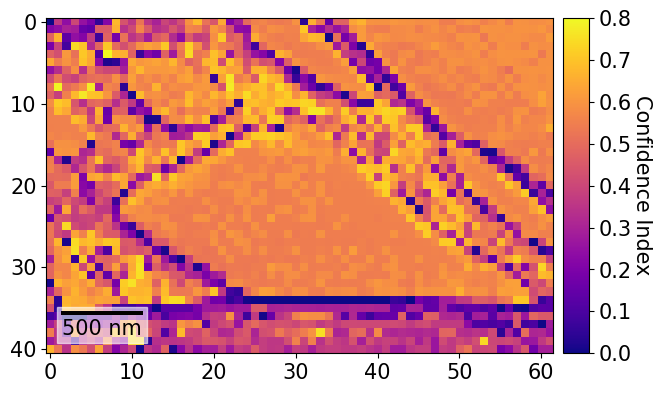

In [93]:
# Confidence index map
fig = xmap.plot(
    xmap.ci,
    cmap="plasma",
    colorbar=True,
    colorbar_label="Confidence Index",
    return_figure=True,
    )

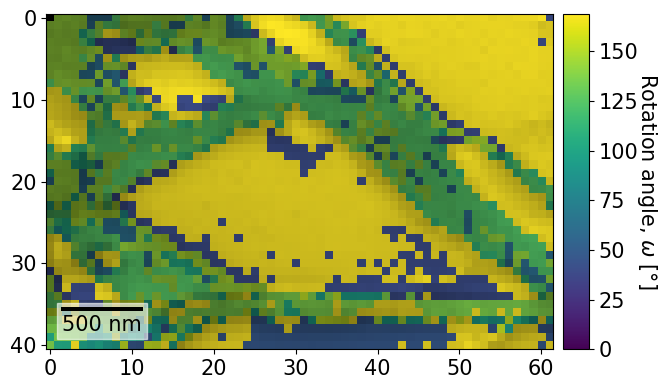

In [94]:
# Get rotation angles in degrees
angles = xmap.rotations.angle * 180 / np.pi

xmap.plot(
    angles,
    vmax=angles.max()-10,
    overlay=xmap.iq,
    colorbar=True,
    colorbar_label=r"Rotation angle, $\omega$ [$\degree$]",
)

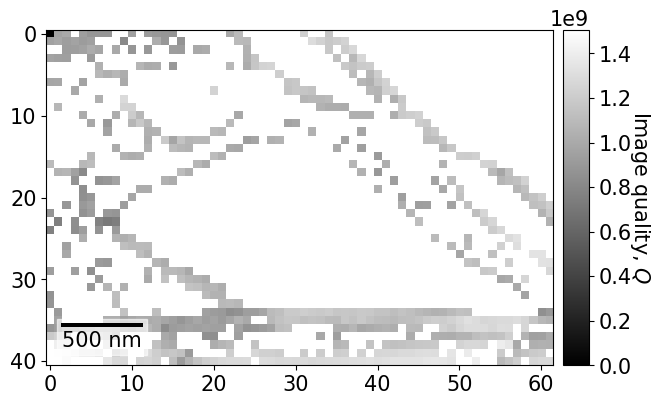

In [31]:
# Conditional slicing：plot the ci value < 0.4 -> boundary
xmap[xmap.ci < 0.4].plot(
    "iq", cmap="gray", colorbar=True, colorbar_label="Image quality, $Q$"
)

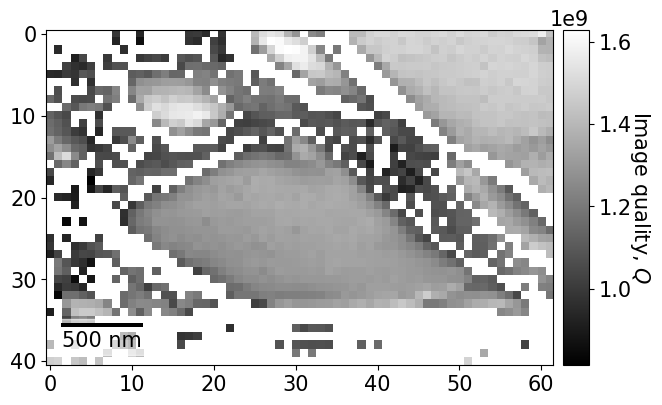

In [ ]:
xmap[xmap.ci > 0.5].plot(
    "iq", cmap="gray", colorbar=True, colorbar_label="Image quality, $Q$"
)

In [11]:
print("The ci value > 0.7, x = ", xmap[xmap.ci > 0.7].x/0.05)
print("The ci value > 0.7, y = ", xmap[xmap.ci > 0.7].y/0.05)

The ci value > 0.7, x =  [31. 21.  3.  7. 14. 17.  4.  7. 17. 22. 26.  1.  5. 22. 28. 39.  4. 22.
 24. 29.  1. 28. 30. 31. 32. 40. 24. 27. 32. 33. 36. 40. 41. 42. 43. 27.
 28. 39. 41. 42. 22. 44. 45. 18. 19. 25. 26. 27. 45. 16. 19. 23. 24. 11.
 16. 42. 38. 41. 13. 15. 39. 55. 40. 41. 51. 56. 41. 47. 58.  2. 45. 46.
 48.  5. 46.  3.  7. 48. 49.  3.  4. 11. 57. 11. 60. 11.  9. 10.  9. 20.
 14. 15. 16. 57. 58. 10. 33. 10. 11. 53.]
The ci value > 0.7, y =  [ 1.  2.  3.  3.  3.  3.  4.  4.  4.  7.  7.  8.  8.  8.  8.  8.  9.  9.
  9.  9. 10. 10. 10. 10. 10. 10. 11. 11. 11. 11. 11. 11. 11. 11. 11. 12.
 12. 12. 12. 12. 13. 13. 13. 14. 14. 14. 14. 14. 14. 15. 15. 15. 15. 16.
 16. 16. 18. 18. 19. 19. 19. 19. 20. 20. 20. 20. 21. 21. 21. 25. 25. 25.
 25. 26. 26. 27. 27. 27. 27. 28. 29. 29. 29. 30. 30. 31. 32. 32. 33. 33.
 34. 34. 34. 34. 34. 38. 38. 39. 39. 39.]


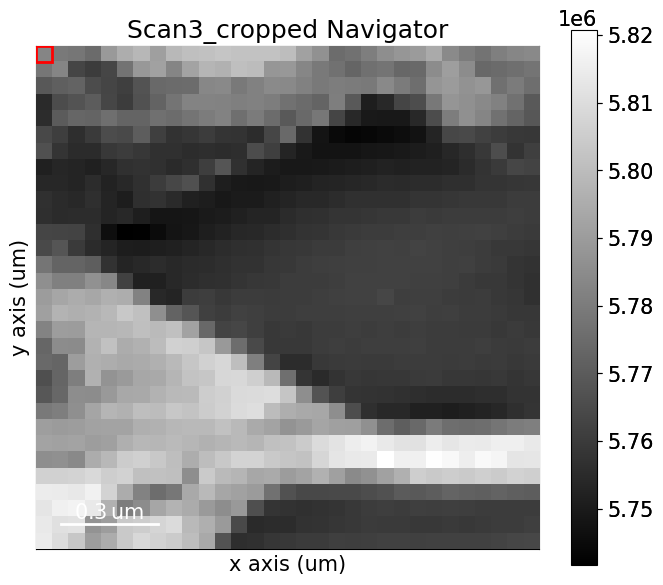

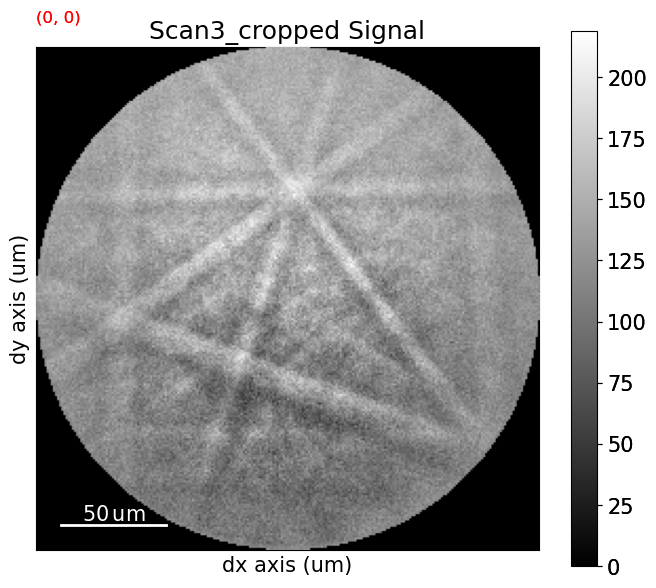

In [12]:
s_edax.inav[5:36,10:41].plot()

In [8]:
s_edax.xmap = xmap
s_edax.xmap.phases

Id   Name  Space group  Point group  Proper point group       Color
 1  Fe3O4        Fd-3m         m-3m                 432   tab:green
 2    FeO        Fm-3m         m-3m                 432  tab:orange
 3     Fe        Im-3m         m-3m                 432    tab:blue

In [90]:
output_dir = "EBSD_scan"
os.makedirs(output_dir, exist_ok=True)  # Create the folder if not existed

# Gain the navigation shape
n_rows, n_cols = s_edax.axes_manager.navigation_shape
print(n_rows, n_cols)
# iterate all the scan points and display the progress
for i in tqdm(range(n_rows)):
    for j in range(n_cols):
        # Obtain the data at [i,j]
        # print(i,j)
        pattern = s_edax.inav[i, j].data

        # Preprocessing normalization?
        # pattern_normalized = (pattern - pattern.min()) / (pattern.max() - pattern.min()) * 255
        # pattern_normalized = pattern_normalized.astype(np.uint8)

        # Define the name of output pictures
        filename = os.path.join(output_dir, f"scan3_x_{i}_y_{j}.jpg")

        # save as jpg(grey figure)
        plt.imsave(filename, pattern, cmap="gray", vmin=pattern.min(), vmax=pattern.max())

62 41


100%|██████████| 62/62 [01:00<00:00,  1.03it/s]


## 1.2 Select initial components

x dimensions 62 
 y dimensions 41 
 in multiples of 1


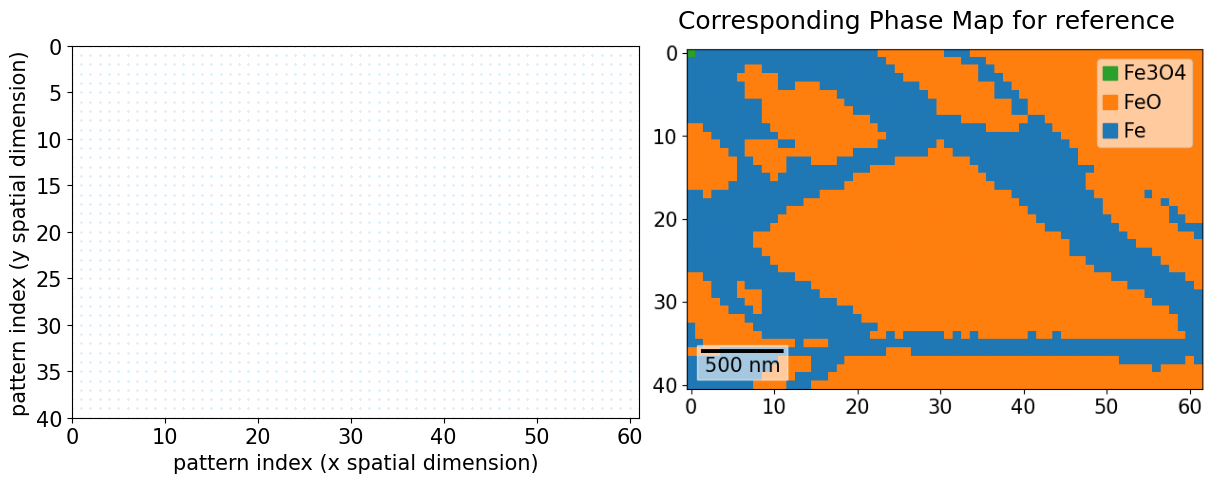

In [9]:
path = "../EBSD_scan/"
grid = read_data(path)

In [10]:
x_range_r1, y_range_r1, x_range_r2, y_range_r2= (30,35), (25,30), (40,45), (12,17)
# s_edax.inav[30:37,25:32].xmap.plot()

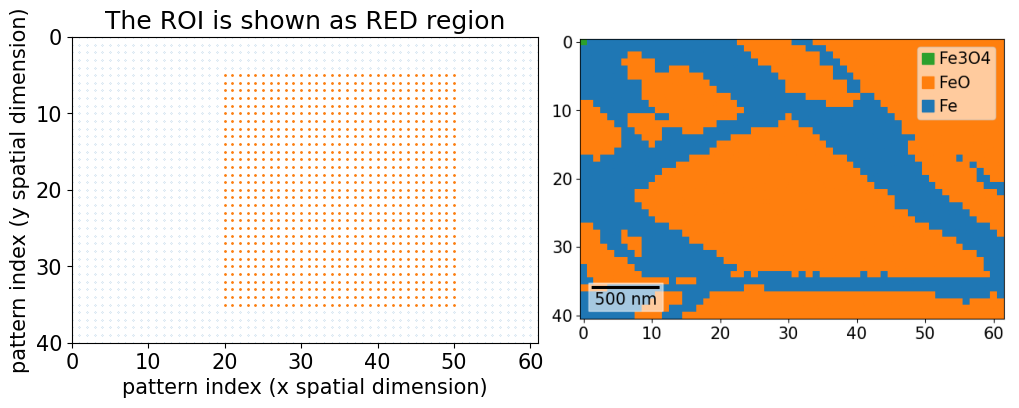

In [11]:
# set roi, get the serial number of ebsp in roi (for getting the phase index later)
R6, loc = set_ROI((20,50),(5,35), path, grid)

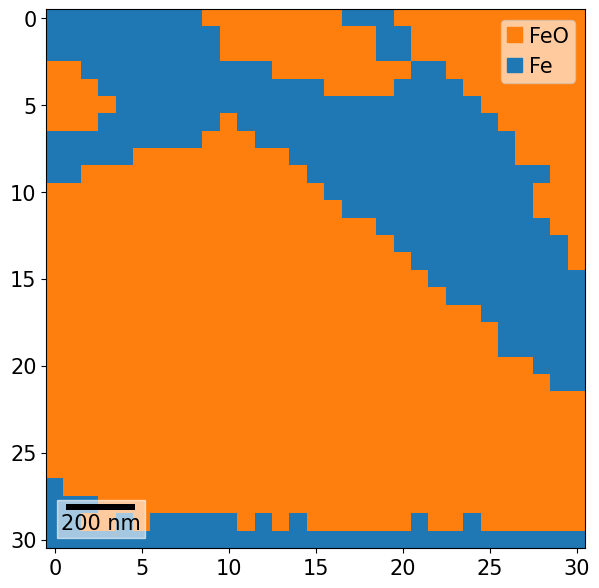

In [13]:
s_edax.inav[20:51,5:36].xmap.plot()

### 1.3 PCA

In [12]:
# dict {x,y} coordinates: phase index (all included)
coor_dict = coord_xmap_dict(s_edax.xmap,0.05)

In [13]:
# weights for each component
pca_scores, pca = run_PCA(R6, 10)

[########################################] | 100% Completed | 113.39 ms
[########################################] | 100% Completed | 112.26 ms
[########################################] | 100% Completed | 113.71 ms
[########################################] | 100% Completed | 121.04 ms
[########################################] | 100% Completed | 118.80 ms
[########################################] | 100% Completed | 119.25 ms
[########################################] | 100% Completed | 119.78 ms
[########################################] | 100% Completed | 120.84 ms
[########################################] | 100% Completed | 119.55 ms
[########################################] | 100% Completed | 108.48 ms
[########################################] | 100% Completed | 108.28 ms
[########################################] | 100% Completed | 109.38 ms
[########################################] | 100% Completed | 119.85 ms
[########################################] | 100% Completed | 11

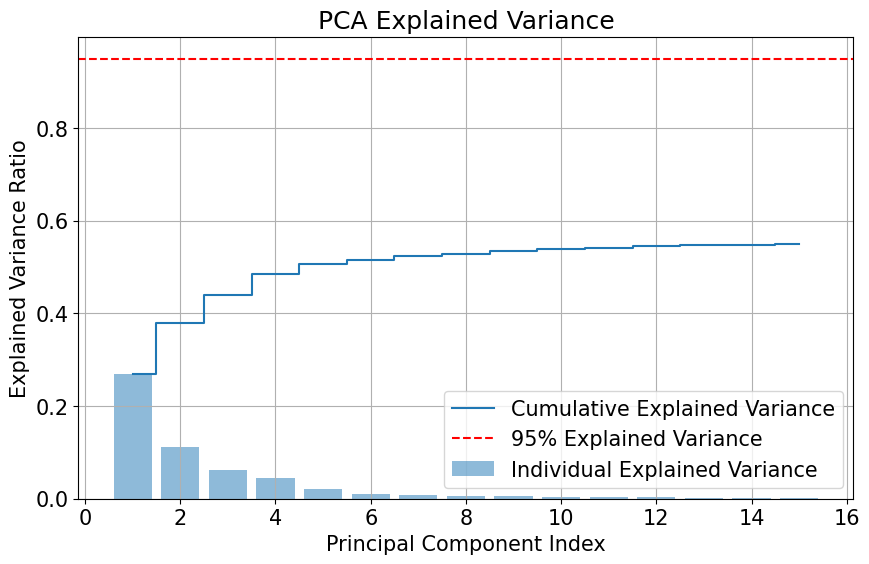

In [32]:
plot_explained_variance(pca)

- The first 8-10 PCs contribute the most variance (nearly 60%) and after the first 10 components, the cumulative curve shows each component explained little variance each.
- That could be several reasons: 
    1) High noise level; 
    2) Redundancy, very closely related features
    3) underlying nonlinear relationship between features

- Solutions:
    1) clustering
    2) Nonlinear DR(t-SNE/UMAP)


> ### GMM clustering

In [14]:
# transform the actual coordinates to the relative coordinates within ROI 
def coord_transform(loc):
    return [(int(x - 20), int(y - 5)) for x, y in loc]
loc_relative = coord_transform(loc)

# transform the key and return new dictionary
def coord_dict_transform(coord_dict):
    return { (int(x-20), int(y-5)) : v for (x, y), v in coord_dict.items() }
coor_dict_roi = coord_xmap_dict(s_edax.inav[20:51,5:36].xmap,0.05)
coor_dict_roi =coord_dict_transform(coor_dict_roi)

Optimal clustering number: 3, silhouette: 0.266


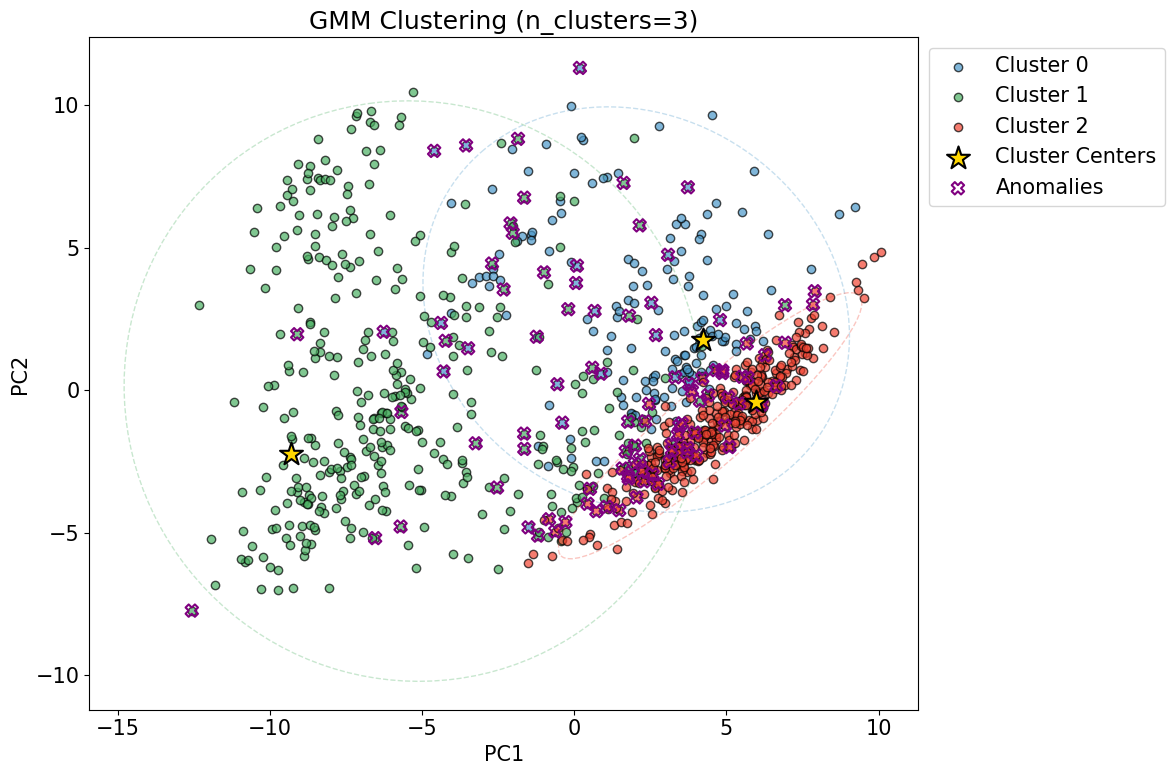

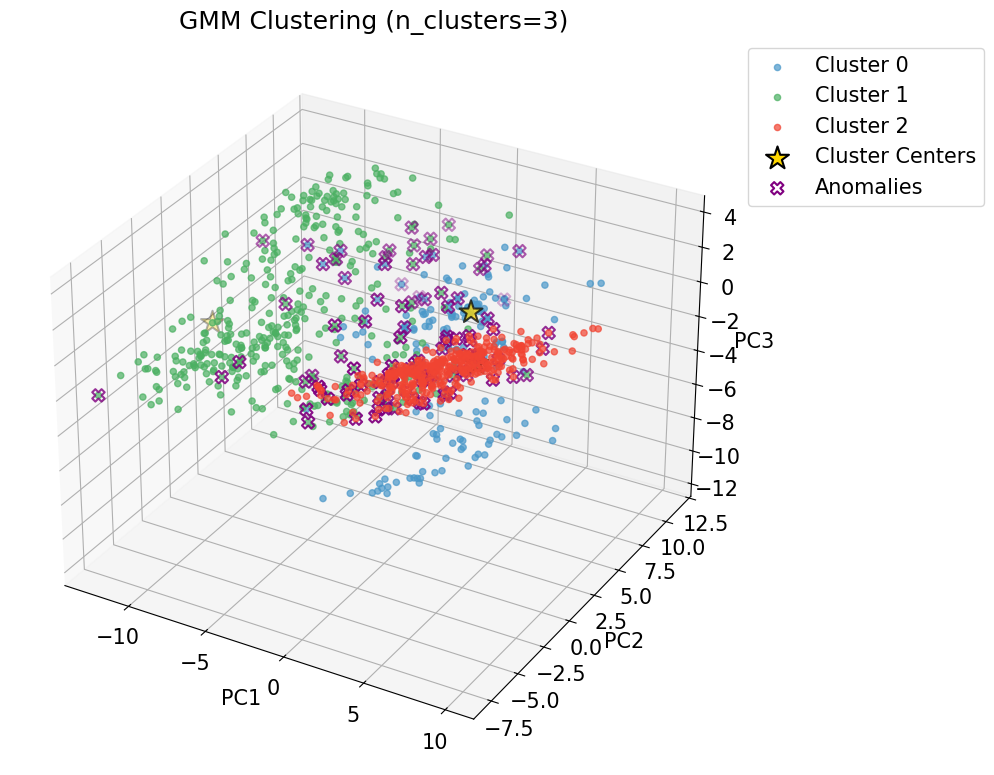

In [15]:
gmm_model1, cluster_coords_c3, cluster_labels1, optimal_n, silhouette = gmm_clustering(pca_scores, loc_relative, 3, 10)
print(f"Optimal clustering number: {optimal_n}, silhouette: {silhouette:.3f}")
coord_to_label3 = {}
for label, coords_list in cluster_coords_c3.items():
    for coord in coords_list:
        coord_tuple = tuple(coord)
        coord_to_label3[coord_tuple] = label
anomalies_cluster_pca_scores3, anomalies_cluster_pca_coords3 = detect_anomalies_pca(pca_scores, coord_to_label3, loc_relative)
centers3, covs3, variations3 = calculate_cluster_metrics(gmm_model1, cluster_labels1, pca_scores)

plot_gmm_clusters(pca_scores, cluster_labels1, optimal_n, variations3, 2, anomalies_cluster_pca_scores3)
plot_gmm_clusters(pca_scores, cluster_labels1, optimal_n, variations3, 3, anomalies_cluster_pca_scores3)

Optimal clustering number: 2, silhouette: 0.317


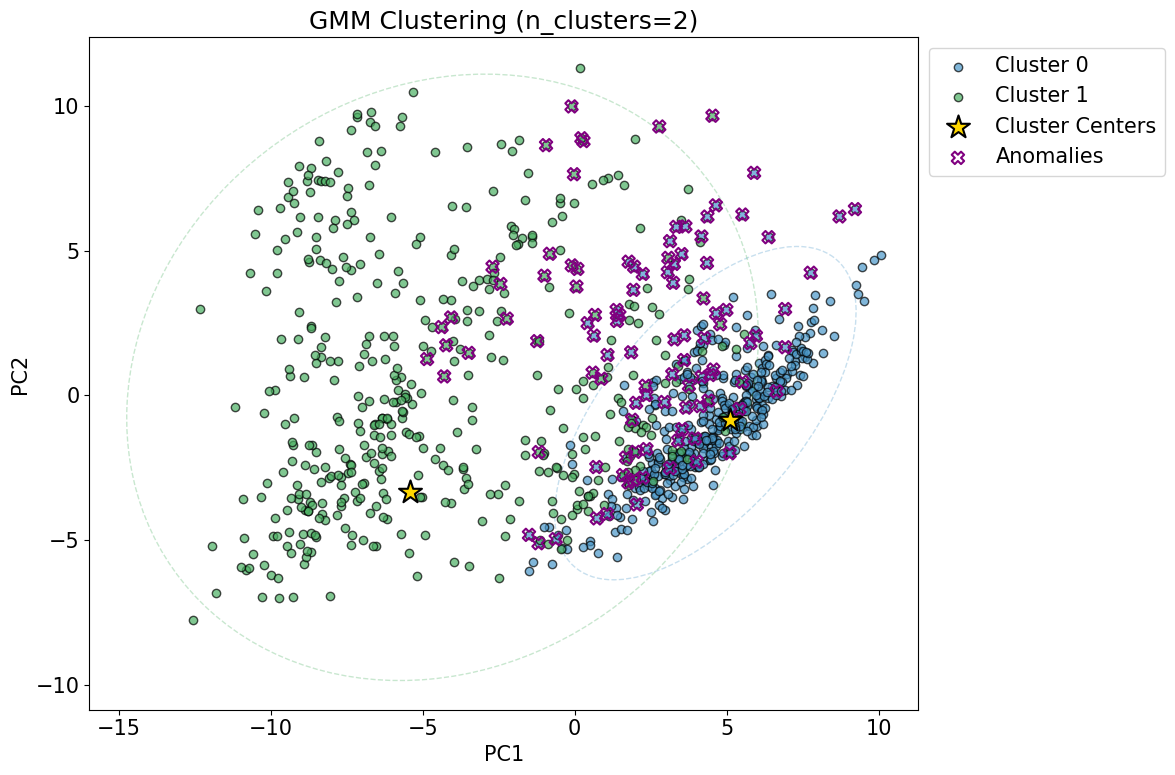

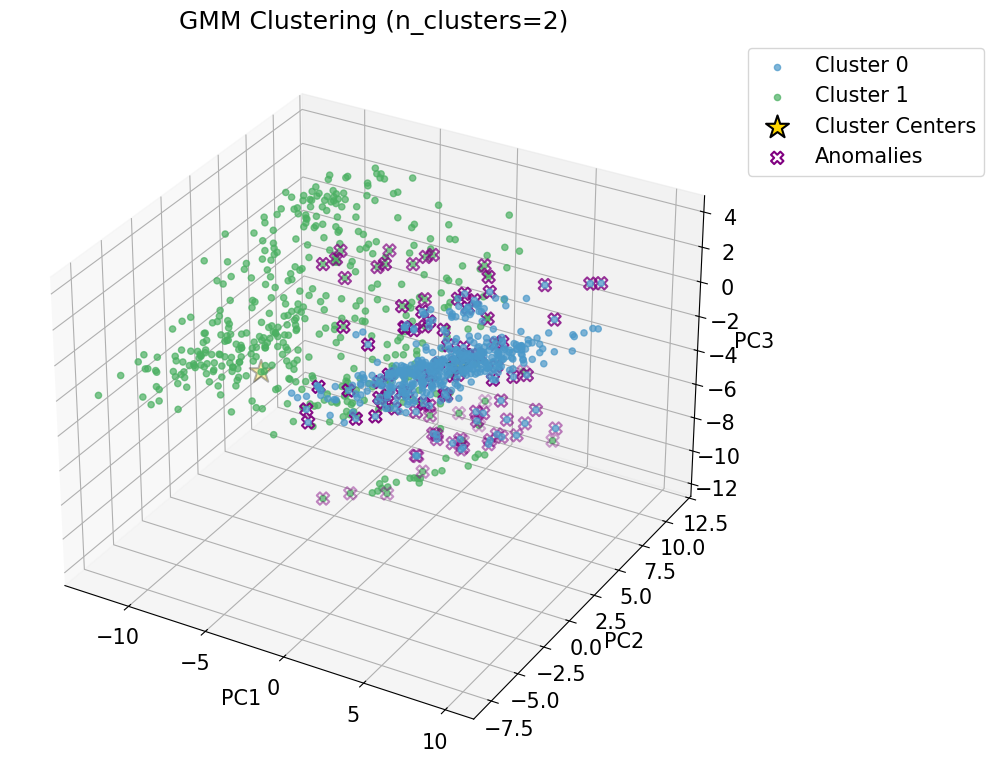

In [16]:
gmm_model2, cluster_coords_c2, cluster_labels2, optimal_n, silhouette = gmm_clustering(pca_scores,loc_relative, None, 10)
print(f"Optimal clustering number: {optimal_n}, silhouette: {silhouette:.3f}")

coord_to_label2 = {}
for label, coords_list in cluster_coords_c2.items():
    for coord in coords_list:
        coord_tuple = tuple(coord)
        coord_to_label2[coord_tuple] = label
anomalies_cluster_pca_scores2, anomalies_cluster_pca_coords2 = detect_anomalies_pca(pca_scores, coord_to_label2, loc_relative)
centers2, covs2, variations2 = calculate_cluster_metrics(gmm_model2, cluster_labels2, pca_scores)

plot_gmm_clusters(pca_scores, cluster_labels2, optimal_n, variations2, 2, anomalies_cluster_pca_scores2)
plot_gmm_clusters(pca_scores, cluster_labels2, optimal_n, variations2, 3, anomalies_cluster_pca_scores2)


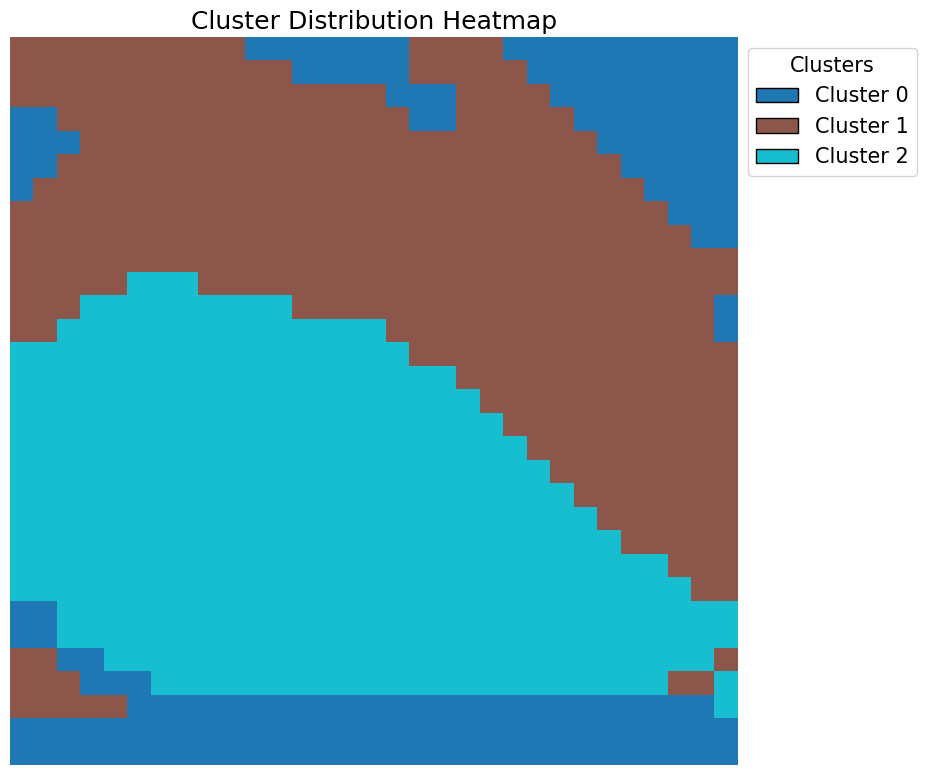

Clustering accuracy: 0.675


In [17]:
plot_cluster_heatmap(cluster_coords_c3,(31,31))
cluster_name_map = {
    1: 'Fe',
    2: 'FeO'
}
name_map = {
    1: 'Fe3O4',
    2: 'FeO',
    3: 'Fe'
}
match_results, acc = clustering_accuracy(coor_dict_roi, coord_to_label3, name_map, cluster_name_map)
print(f"Clustering accuracy: {acc:.3f}")

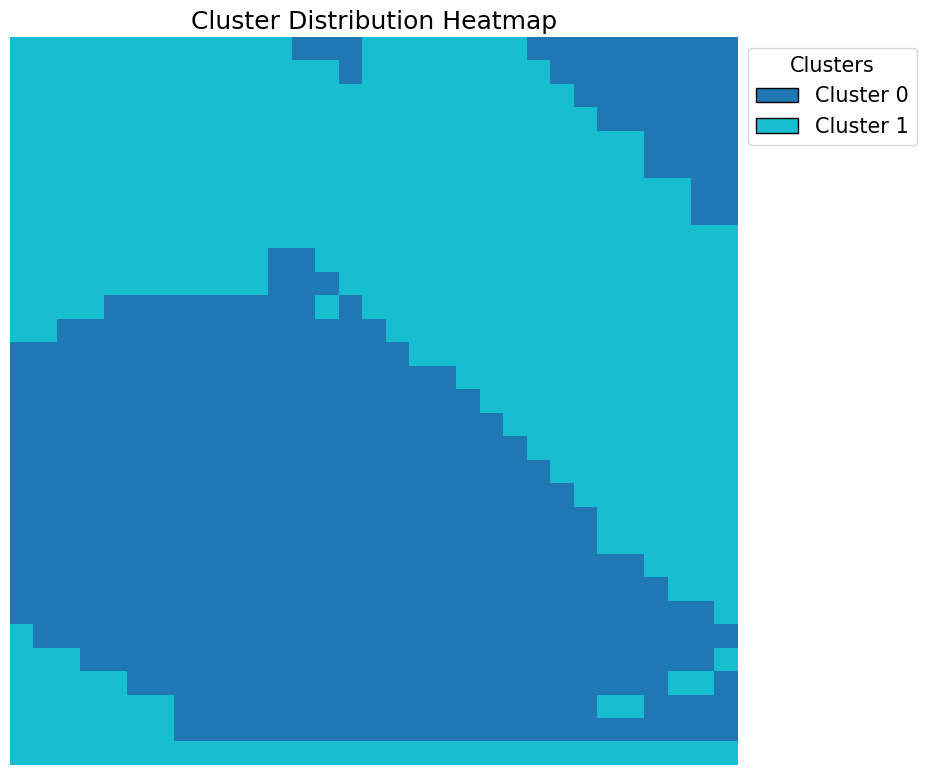

Clustering accuracy: 0.802


In [18]:
plot_cluster_heatmap(cluster_coords_c2,(31,31))

cluster_name_map = {
    0: 'FeO',
    1: 'Fe'
}
name_map = {
    1: 'Fe3O4',
    2: 'FeO',
    3: 'Fe'
}
match_results, acc = clustering_accuracy(coor_dict_roi, coord_to_label2, name_map, cluster_name_map)
print(f"Clustering accuracy: {acc:.3f}")

Cluster centers and corresponding labels: [(27, 1, 0)]
Cluster centers and corresponding labels: [(27, 1, 0), (21, 11, 1)]
Cluster centers and corresponding labels: [(27, 1, 0), (21, 11, 1), (10, 22, 2)]


d:\Material Files\PhD\kikuchi_cnmf\kikuchi-cnmf\micro_segmentation\cluster_analysis.py:323: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


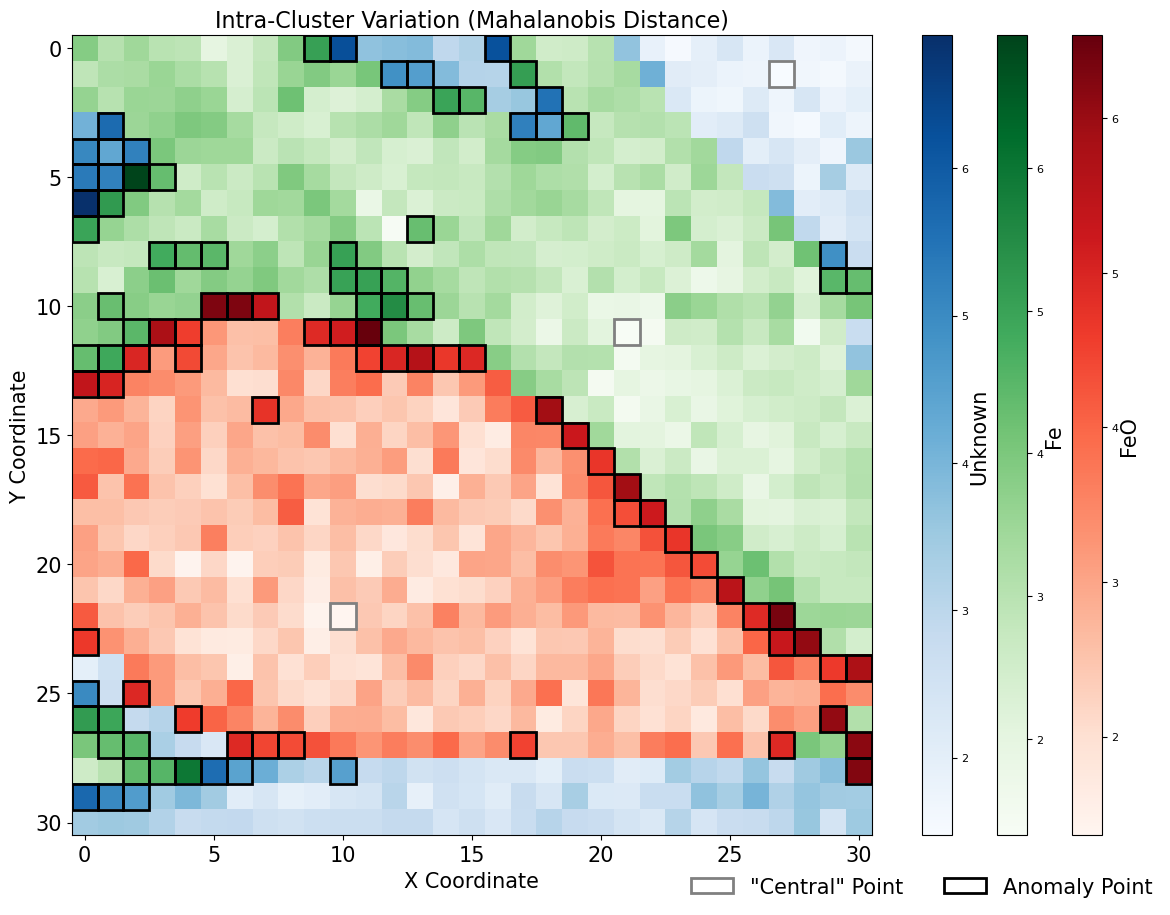

In [19]:
cluster_name_map = {
    0: "Unknown",
    1: "Fe",
    2: "FeO"
}

plot_intra_cluster_variation_map(loc_relative, variations3, cluster_labels1, (31,31), None, cluster_name_map, anomalies_cluster_pca_coords3)

Cluster centers and corresponding labels: [(9, 22, 0)]
Cluster centers and corresponding labels: [(9, 22, 0), (12, 7, 1)]


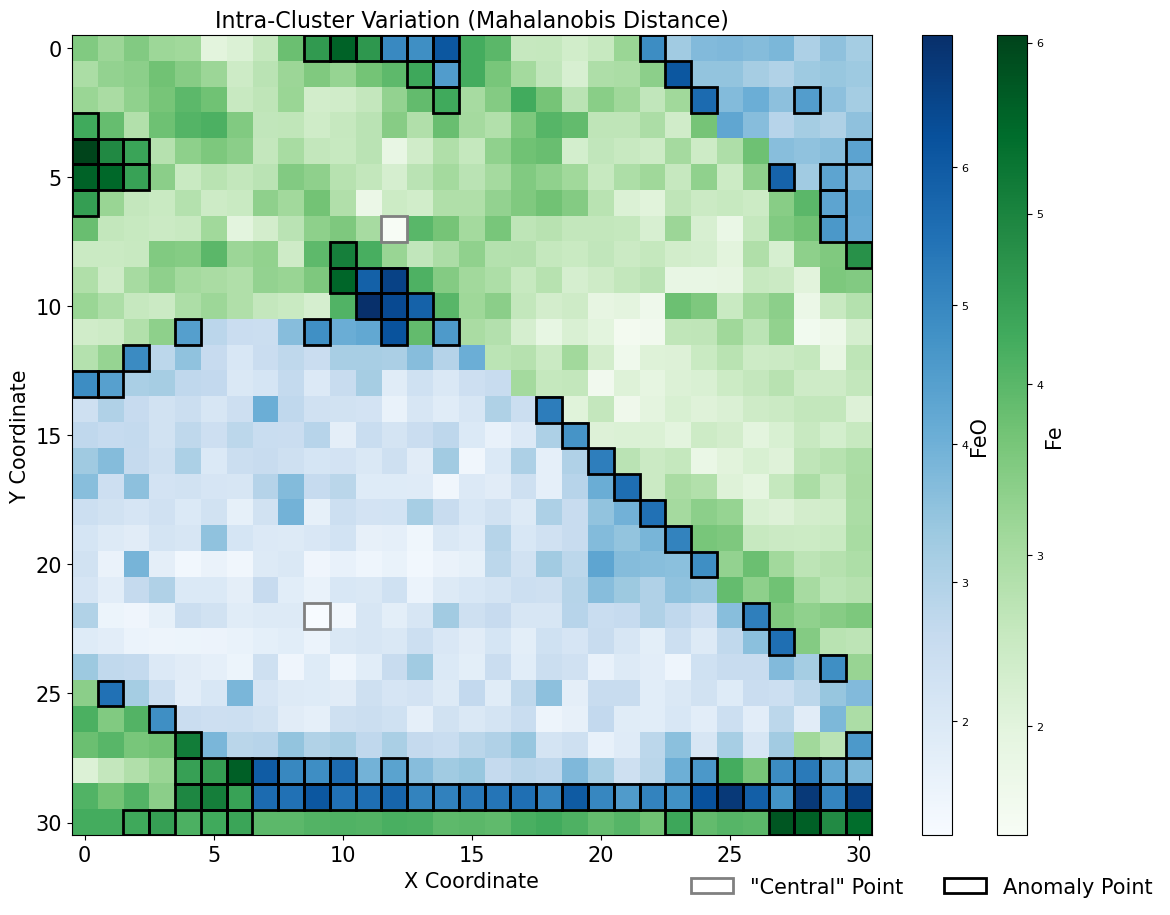

In [20]:
cluster_name_map = {
    0: "FeO",
    1: "Fe"
}

plot_intra_cluster_variation_map(loc_relative, variations2, cluster_labels2, (31,31), None, cluster_name_map, anomalies_cluster_pca_coords2)

- Based on silhouette score, the optimal cluster number is 2 although the score is not quite high (sparse data)/Noise

> ### visualization with the prior indexing 
1. anomalies are regarded to fall out of the 95% confidence interval (assume the data follow the multivariate normal distribution)

In [22]:
# weights for each component
# pca_scores, pca = run_PCA(R6, 2)
# obtain the anomalies
pca_scores_p = pca_scores[:, :2]
anomalies_scores, anomalies_coords = detect_anomalies_pca(pca_scores,coor_dict,loc)

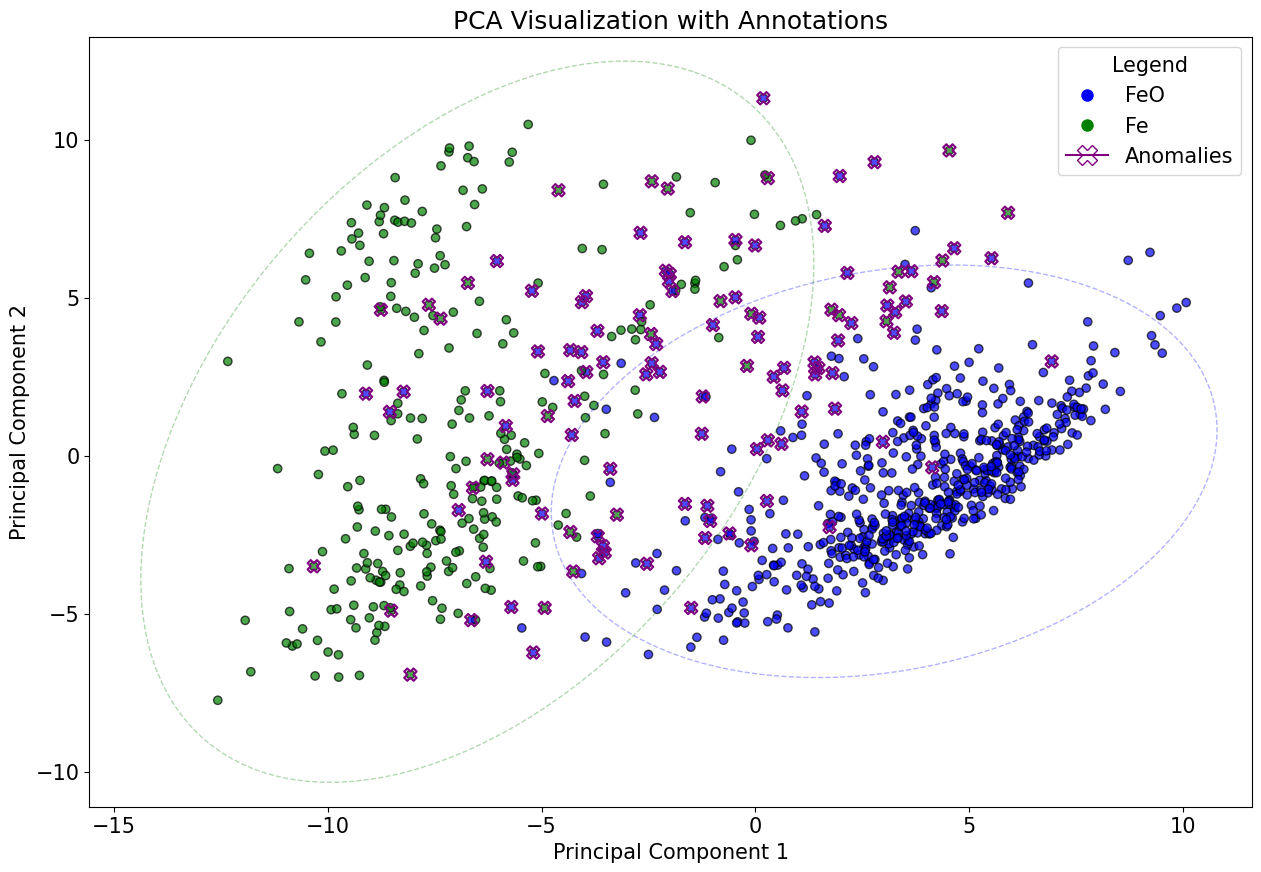

In [23]:
# plot pca weight for points within roi
# _plot_pca(pca_scores, coor_dict, loc)
_plot_pca(pca_scores_p, coor_dict, loc, None, None, anomalies_scores, ellipse_alpha=0.3)

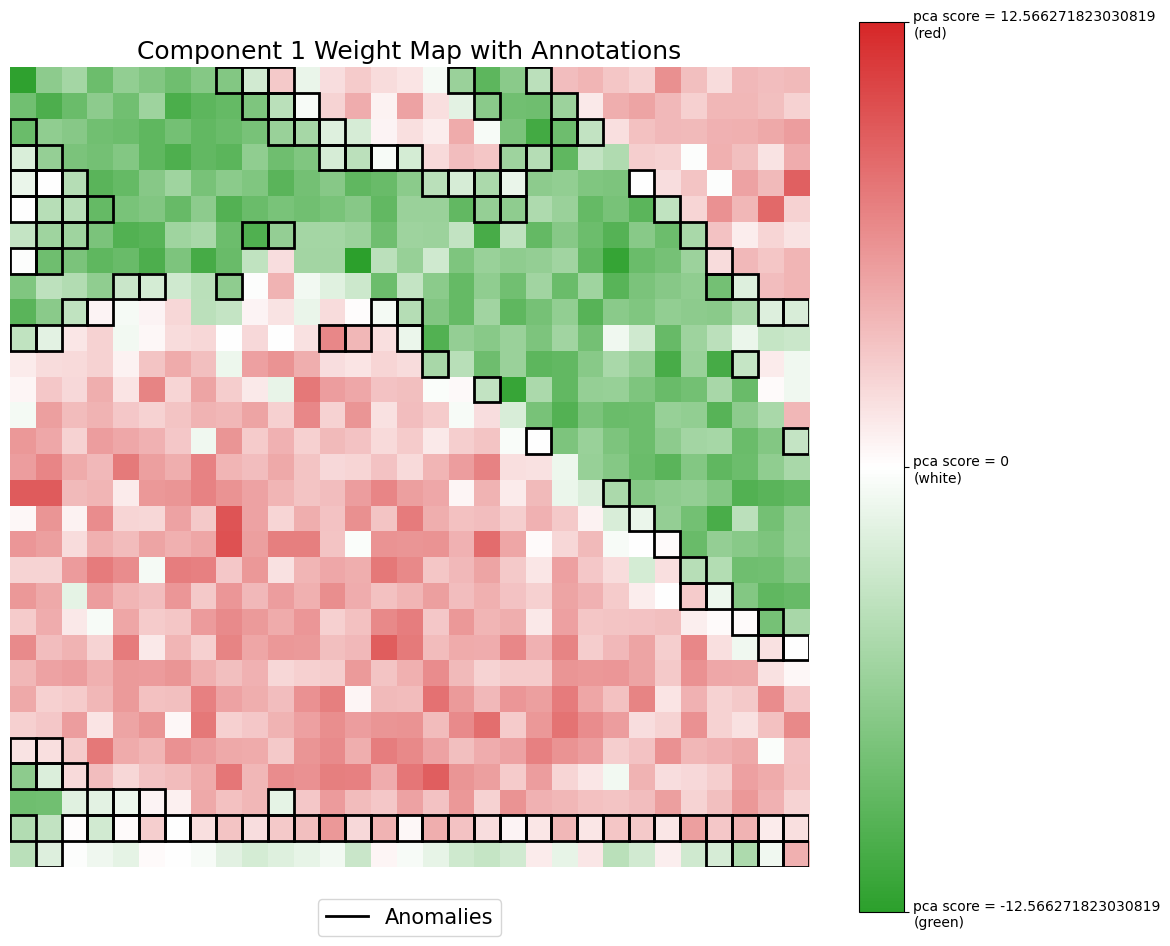

In [25]:
plot_weight_map_pca(pca_scores_p,loc,anomalies_coords,None,None,0)

### 1.4 cNMF

In [13]:
x_range_r1,y_range_r1

((30, 35), (25, 30))

In [ ]:
optimize_results= optimize_paired_components(R6, path, grid, x_range_r1, y_range_r1, x_range_r2, y_range_r2, 2, 2, 3)

In [21]:
np.shape(optimize_results['components'][0])

(2, 22500)

> The optimization here is to select the "best" paired regions (component pairs), evaluate the model performance (such as MSE and R2) for each pair,
    and return the best results.

In [20]:
optimize_results.head(1)


R1_x_range R1_y_range R2_x_range R2_y_range       mse        r2  \
0   (30, 32)   (25, 27)   (40, 42)   (12, 14)  0.000015  0.671728   

                                          components  \
0  [[0.5803921568627451, 0.5529411764705883, 0.58...   

                                             weights  
0  [[[0.30449522, 0.56954694]], [[0.43287674, 0.5...

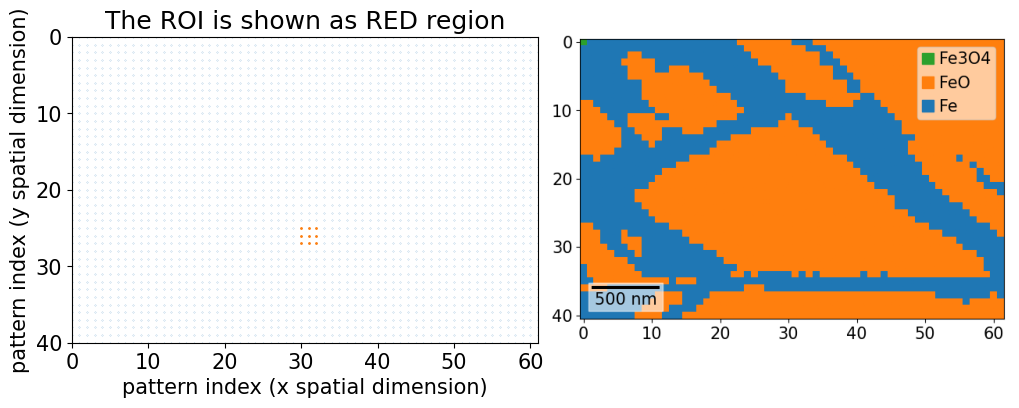

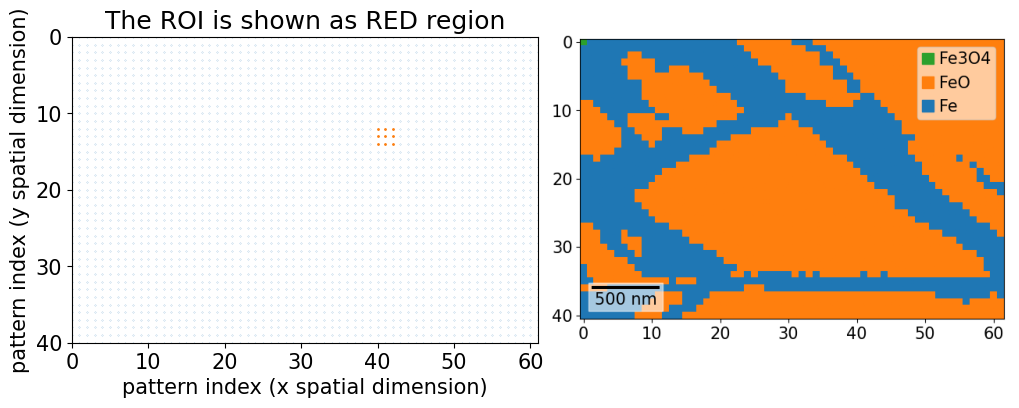

In [21]:
# set components
x_range_1 = (30,32)
y_range_1 = (25,27)
R1, ref1_pos = set_component(x_range_1, y_range_1, path, grid)


x_range_2 = (40,42)
y_range_2 = (12,14)
R2, ref2_pos = set_component(x_range_2, y_range_2, path, grid)

In [22]:
components = get_components(R1, R2)

The component C1 grid shape is (3, 3)
[########################################] | 100% Completed | 228.31 ms
[########################################] | 100% Completed | 115.32 ms
The component C2 grid shape is (3, 3)
[########################################] | 100% Completed | 114.42 ms
[########################################] | 100% Completed | 118.64 ms


In [23]:
# run cNMF
weights,mse,r_square = run_cNMF(R6, components)

[########################################] | 100% Completed | 123.32 ms


[########################################] | 100% Completed | 117.14 ms
[########################################] | 100% Completed | 115.29 ms
[########################################] | 100% Completed | 126.55 ms
[########################################] | 100% Completed | 118.51 ms
[########################################] | 100% Completed | 127.91 ms
[########################################] | 100% Completed | 125.48 ms
[########################################] | 100% Completed | 115.35 ms
[########################################] | 100% Completed | 115.90 ms
[########################################] | 100% Completed | 121.58 ms
[########################################] | 100% Completed | 116.32 ms
[########################################] | 100% Completed | 115.23 ms
[########################################] | 100% Completed | 111.43 ms
[########################################] | 100% Completed | 117.24 ms
[########################################] | 100% Completed | 11

> ### gmm clustering on cnmf weights

Optimal clustering number: 2, silhouette: 0.697


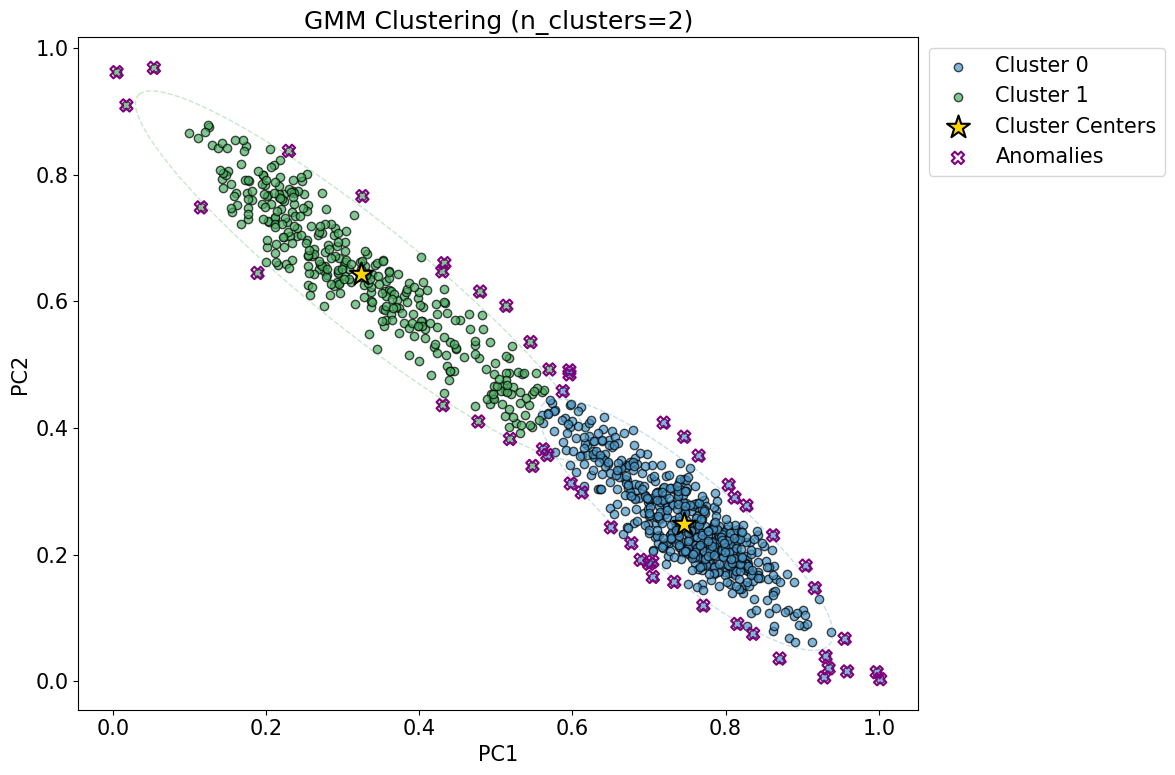

In [28]:
gmm_model3, cluster_coords_cnmf1, cluster_labels_cnmf1, optimal_n, silhouette = gmm_clustering(weights, loc_relative, None, 10)
print(f"Optimal clustering number: {optimal_n}, silhouette: {silhouette:.3f}")
coord_to_label_cnmf1 = {}
for label, coords_list in cluster_coords_cnmf1.items():
    for coord in coords_list:
        coord_tuple = tuple(coord)
        coord_to_label_cnmf1[coord_tuple] = label
anomalies_cluster_cnmf_weights, anomalies_cluster_cnmf_coords = detect_anomalies_cnmf(weights, coord_to_label_cnmf1, loc_relative)
centers_c, covs_c, variations_c = calculate_cluster_metrics(gmm_model3, cluster_labels_cnmf1, weights)

plot_gmm_clusters(weights, cluster_labels_cnmf1, optimal_n, variations_c, 2, anomalies_cluster_cnmf_weights)

Optimal clustering number: 3, silhouette: 0.592


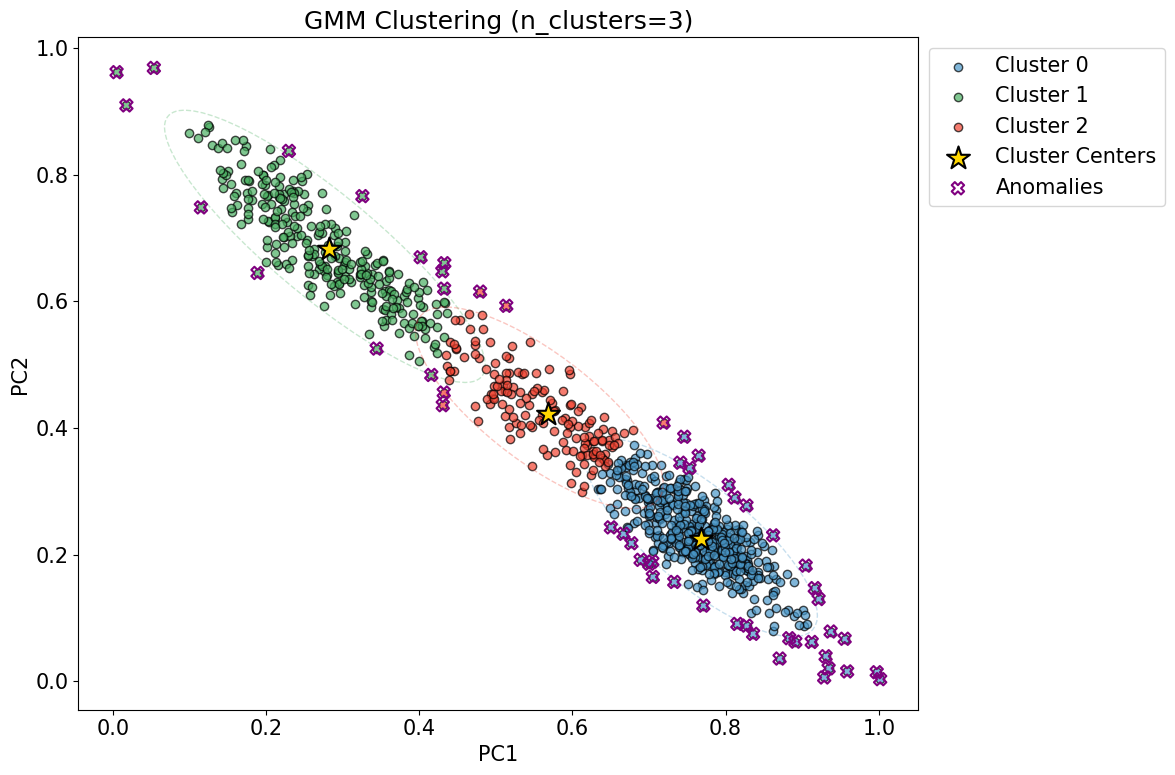

In [29]:
gmm_model4, cluster_coords_cnmf2, cluster_labels_cnmf2, optimal_n, silhouette = gmm_clustering(weights, loc_relative, 3, 10)
print(f"Optimal clustering number: {optimal_n}, silhouette: {silhouette:.3f}")
coord_to_label_cnmf2 = {}
for label, coords_list in cluster_coords_cnmf2.items():
    for coord in coords_list:
        coord_tuple = tuple(coord)
        coord_to_label_cnmf2[coord_tuple] = label
anomalies_cluster_cnmf_weights2, anomalies_cluster_cnmf_coords2 = detect_anomalies_cnmf(weights, coord_to_label_cnmf2, loc_relative)
centers_c2, covs_c2, variations_c2 = calculate_cluster_metrics(gmm_model4, cluster_labels_cnmf2, weights)

plot_gmm_clusters(weights, cluster_labels_cnmf2, optimal_n, variations_c2, 2, anomalies_cluster_cnmf_weights2)

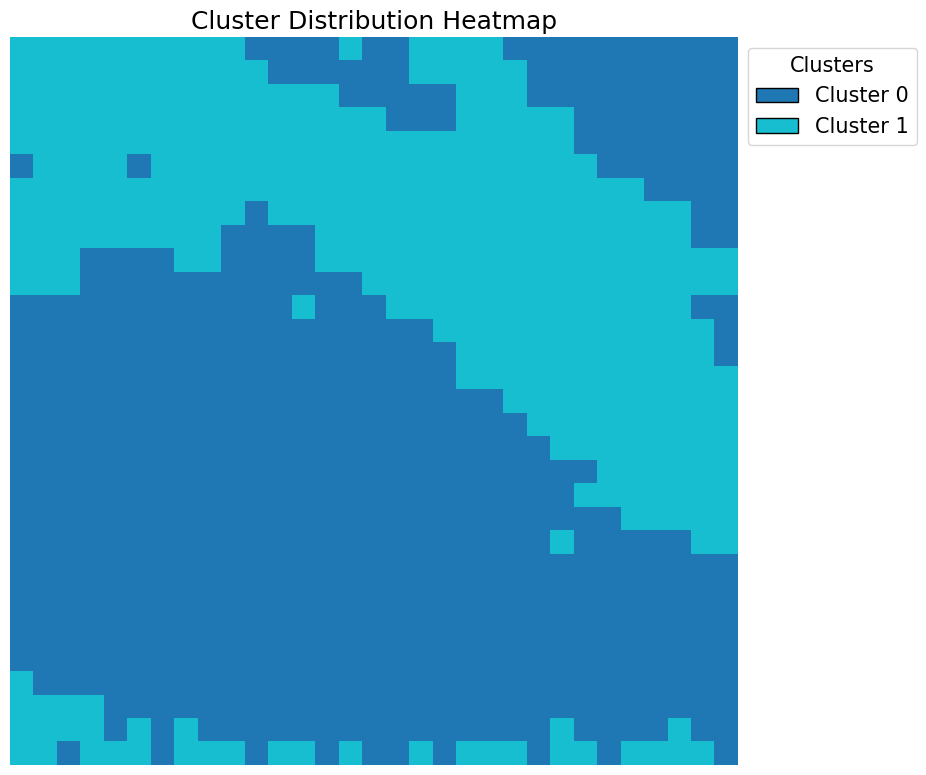

Clustering accuracy: 0.891


In [31]:
plot_cluster_heatmap(cluster_coords_cnmf1,(31,31))

cluster_name_map = {
    0: 'FeO',
    1: 'Fe'
}
name_map = {
    1: 'Fe3O4',
    2: 'FeO',
    3: 'Fe'
}
match_results, acc = clustering_accuracy(coor_dict_roi, coord_to_label_cnmf1, name_map, cluster_name_map)
print(f"Clustering accuracy: {acc:.3f}")


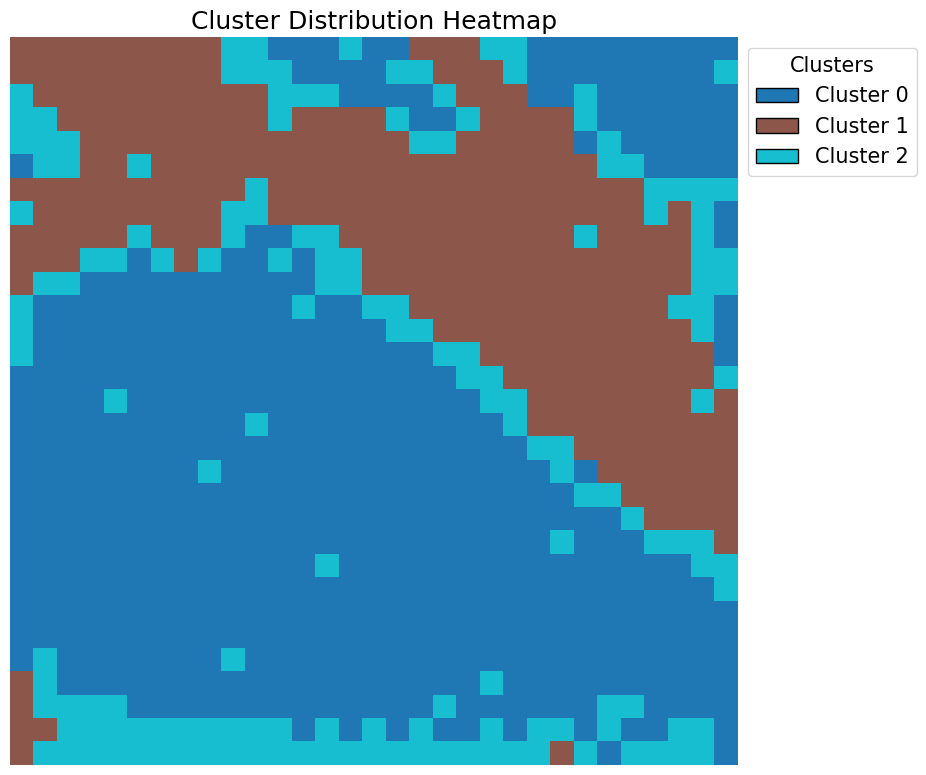

Clustering accuracy: 0.794


In [33]:
plot_cluster_heatmap(cluster_coords_cnmf2,(31,31))

cluster_name_map = {
    0: 'FeO',
    1: 'Fe',
}
name_map = {
    1: 'Fe3O4',
    2: 'FeO',
    3: 'Fe'
}
match_results, acc = clustering_accuracy(coor_dict_roi, coord_to_label_cnmf2, name_map, cluster_name_map)
print(f"Clustering accuracy: {acc:.3f}")

Cluster centers and corresponding labels: [(16, 15, 0)]
Cluster centers and corresponding labels: [(16, 15, 0), (19, 0, 1)]


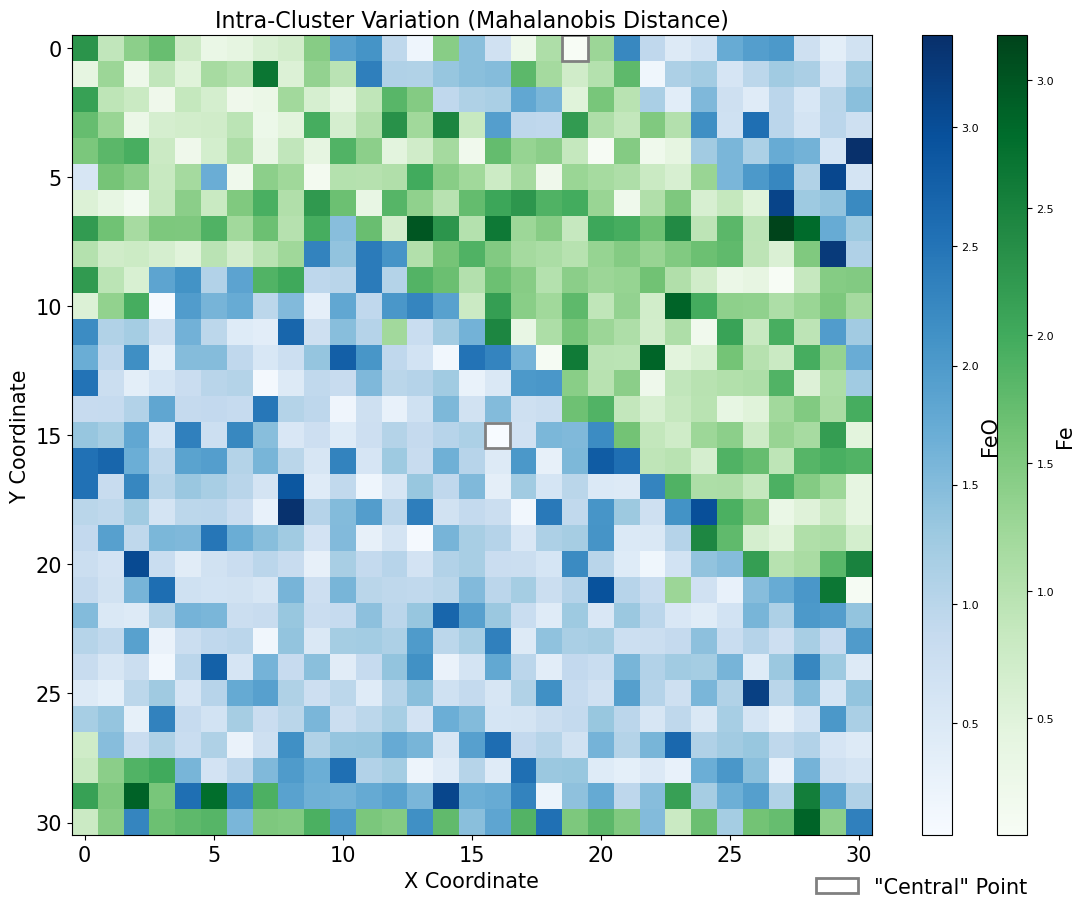

In [40]:
cluster_name_map = {
    0: 'FeO',
    1: 'Fe'
}
plot_intra_cluster_variation_map(loc_relative, variations_c, cluster_labels_cnmf1, (31,31), None, cluster_name_map, None)

Cluster centers and corresponding labels: [(18, 16, 0)]
Cluster centers and corresponding labels: [(18, 16, 0), (25, 14, 1)]
Cluster centers and corresponding labels: [(18, 16, 0), (25, 14, 1), (30, 6, 2)]


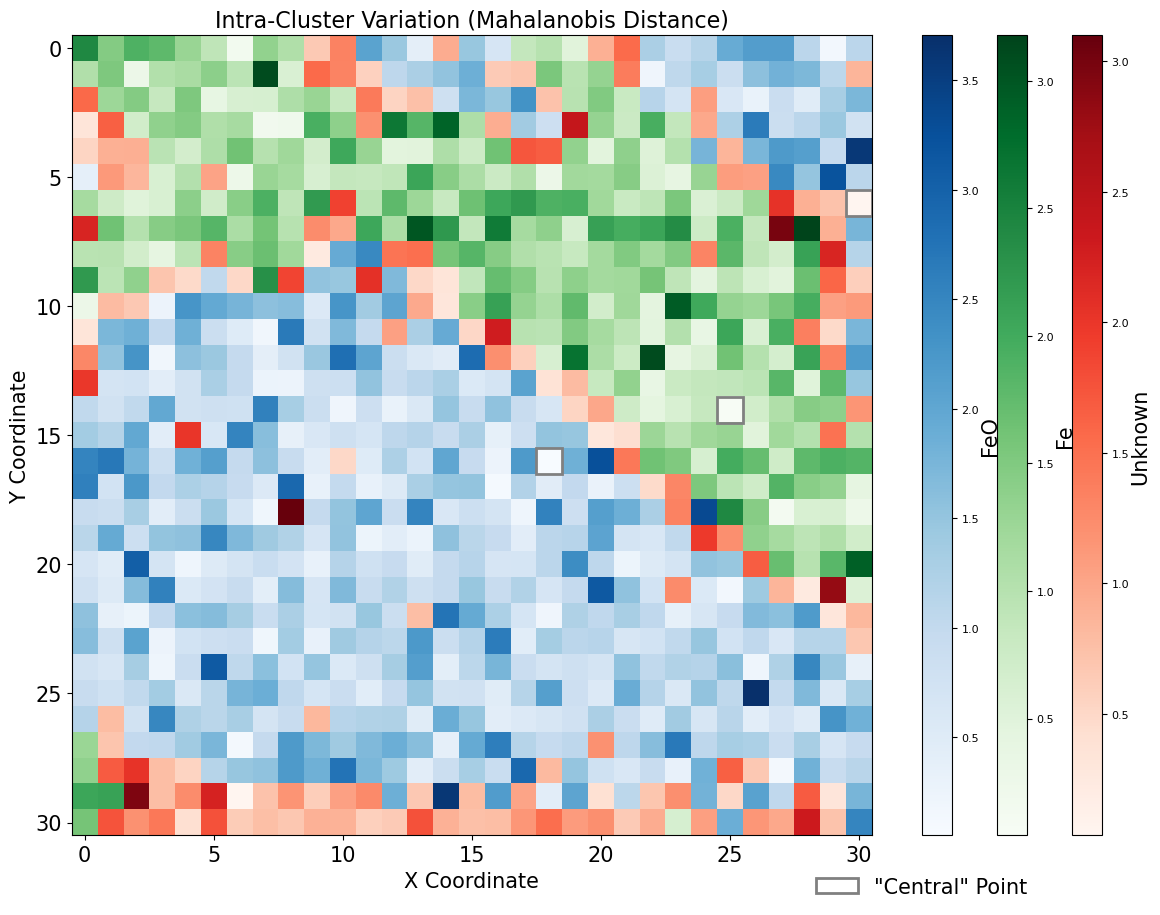

In [41]:
cluster_name_map = {
    0: 'FeO',
    1: 'Fe',
    2: 'Unknown'
}
plot_intra_cluster_variation_map(loc_relative, variations_c2, cluster_labels_cnmf2, (31,31), None, cluster_name_map, None)

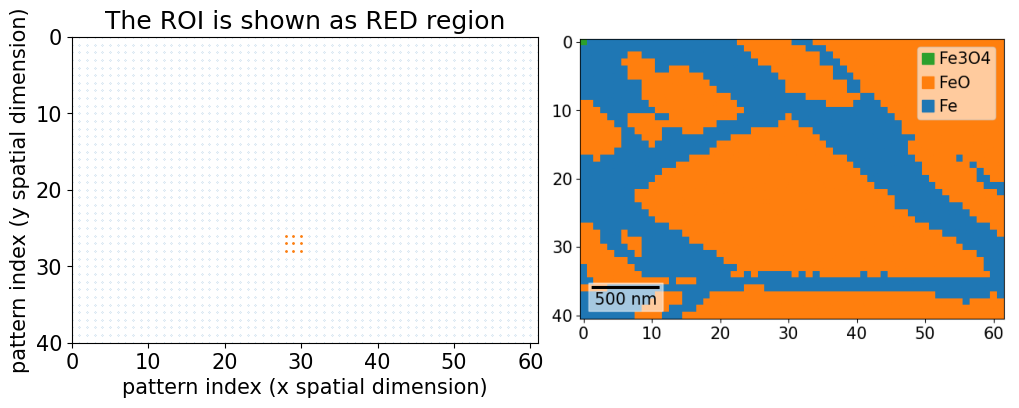

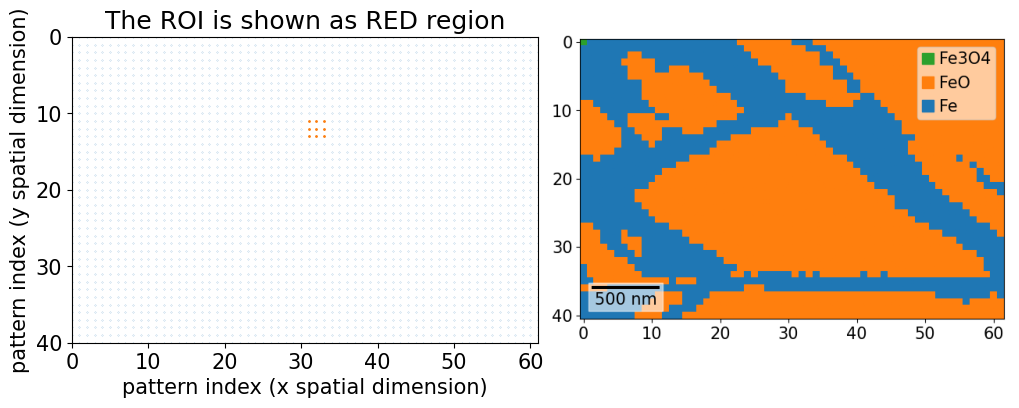

In [81]:
# set components based on pca scores clustering central points
x_range_1 = (28,30)
y_range_1 = (26,28)
R3, ref3_pos = set_component(x_range_1, y_range_1, path, grid)


x_range_2 = (31,33)
y_range_2 = (11,13)
R4, ref4_pos = set_component(x_range_2, y_range_2, path, grid)

The component C1 grid shape is (3, 3)
[                                        ] | 0% Completed | 2.74 ms

[########################################] | 100% Completed | 113.11 ms
[########################################] | 100% Completed | 106.48 ms
The component C2 grid shape is (3, 3)
[########################################] | 100% Completed | 108.54 ms
[########################################] | 100% Completed | 135.40 ms
[########################################] | 100% Completed | 129.47 ms
[########################################] | 100% Completed | 111.35 ms
[########################################] | 100% Completed | 106.70 ms
[########################################] | 100% Completed | 104.87 ms
[########################################] | 100% Completed | 104.44 ms
[########################################] | 100% Completed | 110.73 ms
[########################################] | 100% Completed | 106.77 ms
[########################################] | 100% Completed | 106.31 ms
[########################################] | 100% Completed | 105.90 ms
[#########################

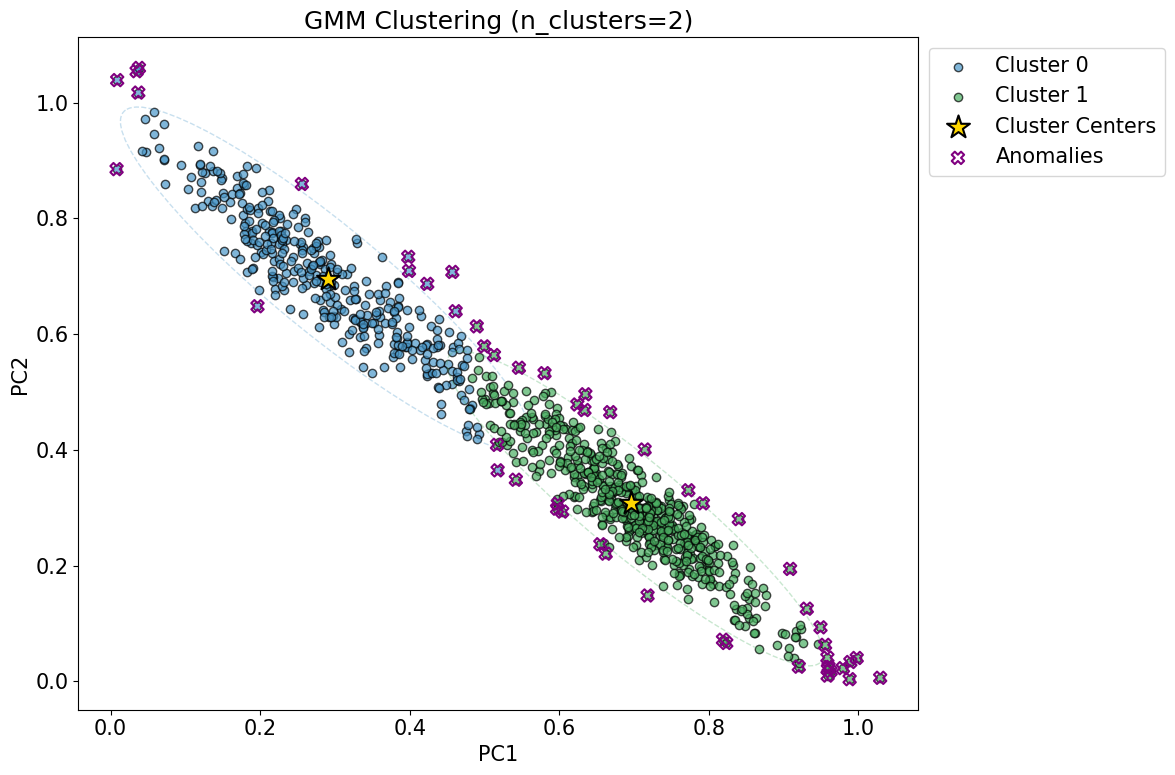

In [67]:
components = get_components(R3, R4)

# run cNMF
weights,mse,r_square = run_cNMF(R6, components)


gmm_model5, cluster_coords_cnmf3, cluster_labels_cnmf3, optimal_n, silhouette = gmm_clustering(weights, loc_relative, None, 10)
print(f"Optimal clustering number: {optimal_n}, silhouette: {silhouette:.3f}")
coord_to_label_cnmf3 = {}
for label, coords_list in cluster_coords_cnmf3.items():
    for coord in coords_list:
        coord_tuple = tuple(coord)
        coord_to_label_cnmf3[coord_tuple] = label
anomalies_cluster_cnmf_weights3, anomalies_cluster_cnmf_coords3 = detect_anomalies_cnmf(weights, coord_to_label_cnmf3, loc_relative)
centers_c3, covs_c3, variations_c3 = calculate_cluster_metrics(gmm_model5, cluster_labels_cnmf3, weights)

plot_gmm_clusters(weights, cluster_labels_cnmf3, optimal_n, variations_c3, 2, anomalies_cluster_cnmf_weights3)

Optimal clustering number: 3, silhouette: 0.494


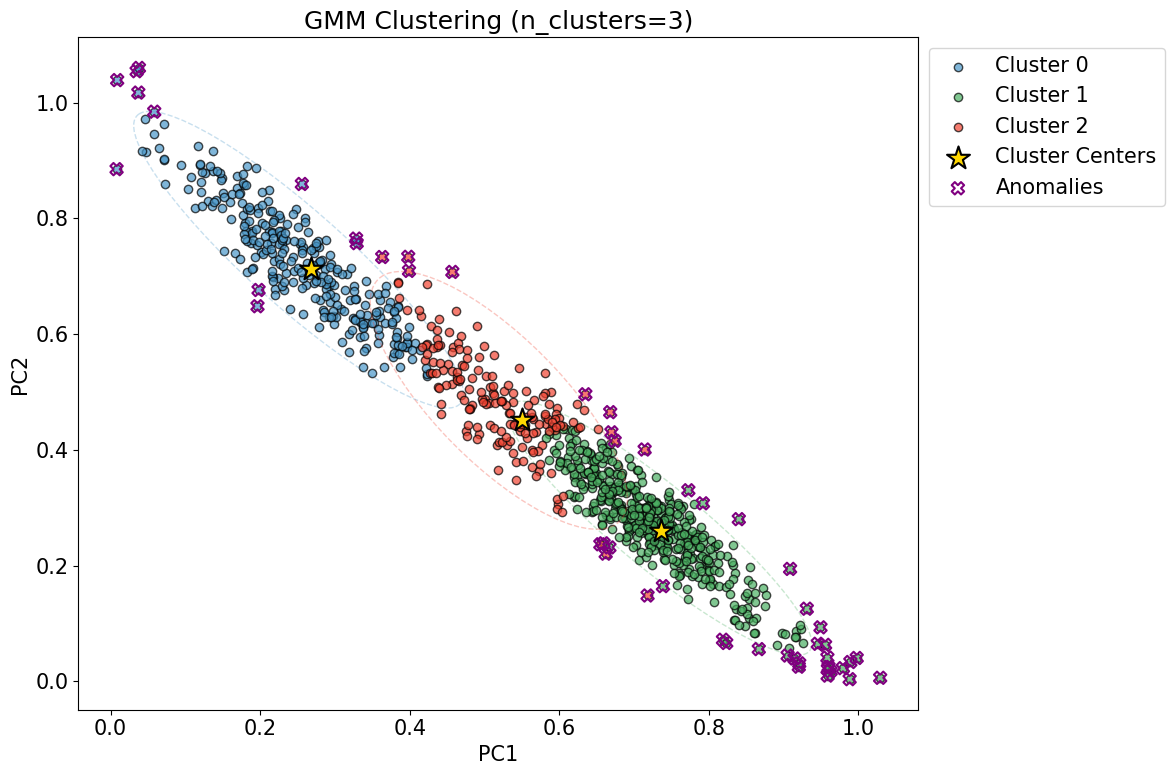

In [71]:
gmm_model6, cluster_coords_cnmf4, cluster_labels_cnmf4, optimal_n, silhouette = gmm_clustering(weights, loc_relative, 3, 10)
print(f"Optimal clustering number: {optimal_n}, silhouette: {silhouette:.3f}")
coord_to_label_cnmf4 = {}
for label, coords_list in cluster_coords_cnmf4.items():
    for coord in coords_list:
        coord_tuple = tuple(coord)
        coord_to_label_cnmf4[coord_tuple] = label
anomalies_cluster_cnmf_weights4, anomalies_cluster_cnmf_coords4 = detect_anomalies_cnmf(weights, coord_to_label_cnmf4, loc_relative)
centers_c4, covs_c4, variations_c4 = calculate_cluster_metrics(gmm_model6, cluster_labels_cnmf4, weights)

plot_gmm_clusters(weights, cluster_labels_cnmf4, optimal_n, variations_c4, 2, anomalies_cluster_cnmf_weights4)

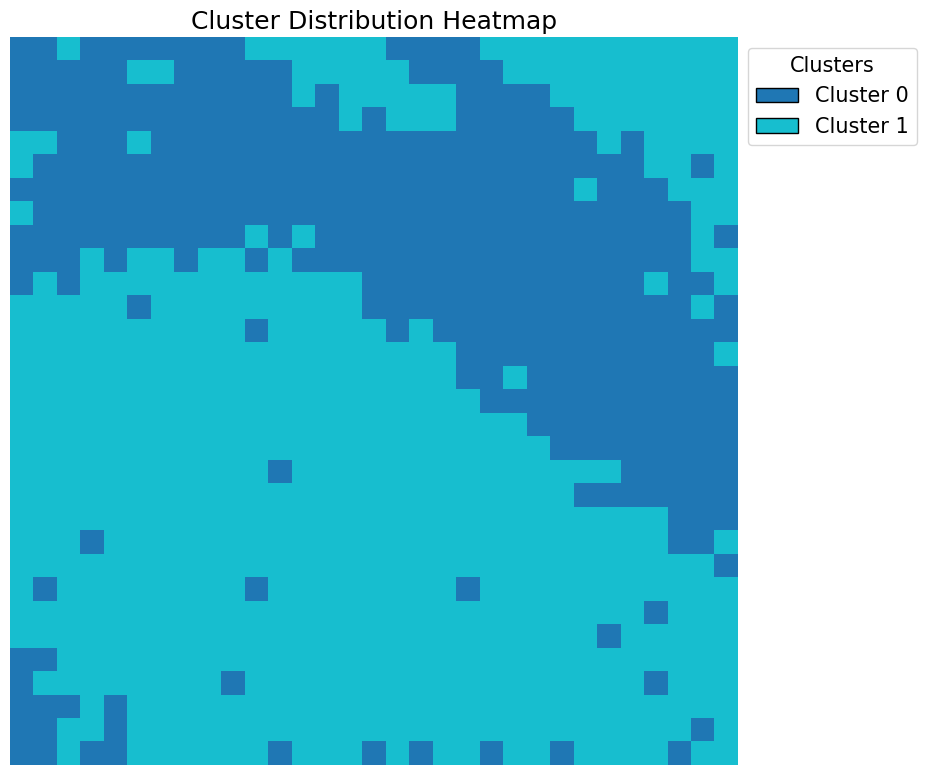

Clustering accuracy: 0.855


In [69]:
plot_cluster_heatmap(cluster_coords_cnmf3,(31,31))

cluster_name_map = {
    0: 'Fe',
    1: 'FeO'
}
name_map = {
    1: 'Fe3O4',
    2: 'FeO',
    3: 'Fe'
}
match_results, acc = clustering_accuracy(coor_dict_roi, coord_to_label_cnmf3, name_map, cluster_name_map)
print(f"Clustering accuracy: {acc:.3f}")

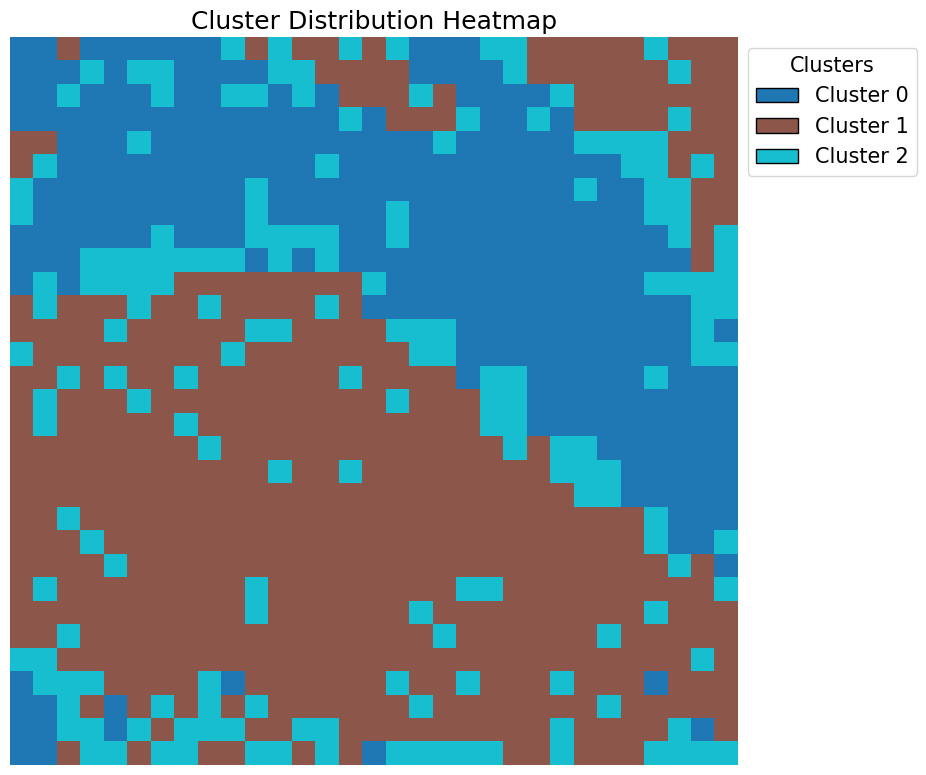

Clustering accuracy: 0.742


In [72]:
plot_cluster_heatmap(cluster_coords_cnmf4,(31,31))

cluster_name_map = {
    0: 'Fe',
    1: 'FeO'
}
name_map = {
    1: 'Fe3O4',
    2: 'FeO',
    3: 'Fe'
}
match_results, acc = clustering_accuracy(coor_dict_roi, coord_to_label_cnmf4, name_map, cluster_name_map)
print(f"Clustering accuracy: {acc:.3f}")

Cluster centers and corresponding labels: [(25, 13, 0)]
Cluster centers and corresponding labels: [(25, 13, 0), (22, 20, 1)]


d:\Material Files\PhD\kikuchi_cnmf\kikuchi-cnmf\micro_segmentation\cluster_analysis.py:323: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


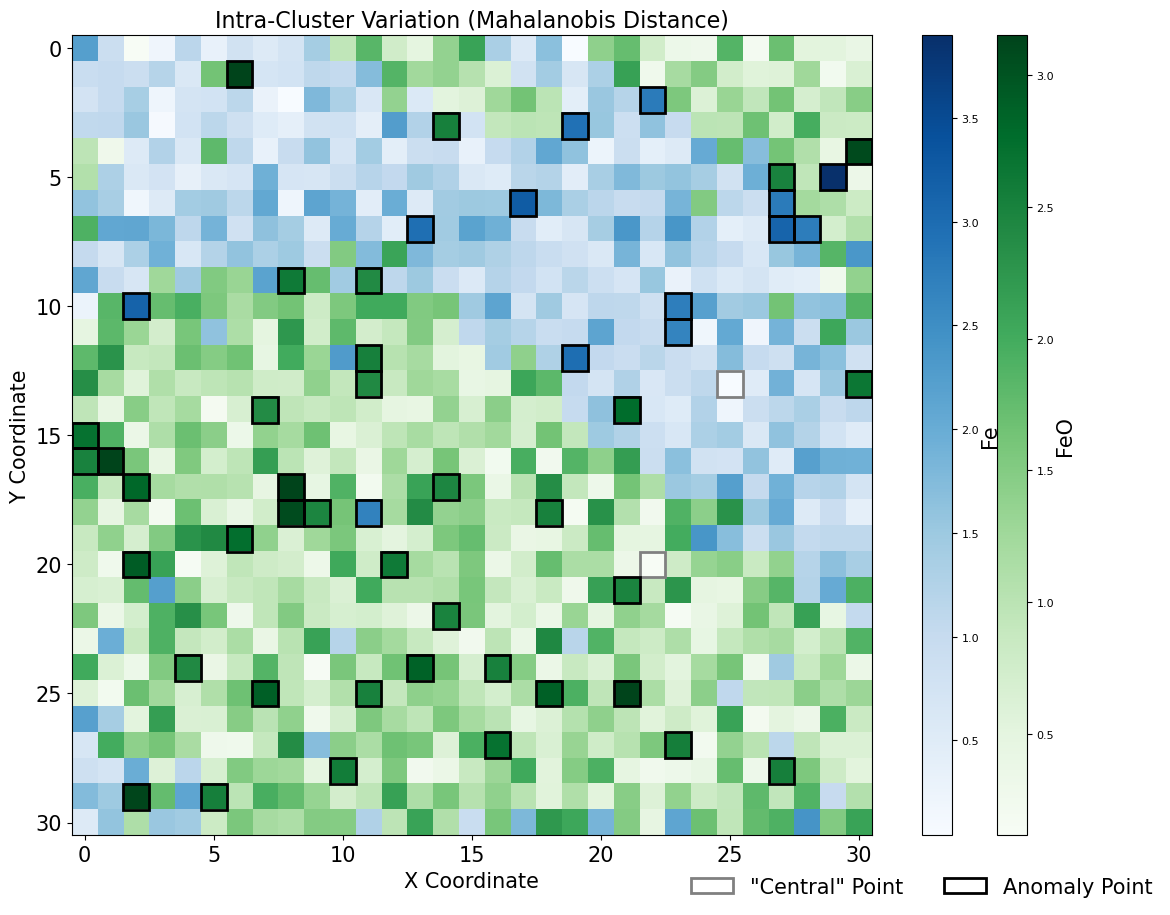

In [74]:
plot_intra_cluster_variation_map(loc_relative, variations_c3, cluster_labels_cnmf3, (31,31), None, cluster_name_map, anomalies_cluster_cnmf_coords3)

Cluster centers and corresponding labels: [(25, 14, 0)]
Cluster centers and corresponding labels: [(25, 14, 0), (18, 22, 1)]
Cluster centers and corresponding labels: [(25, 14, 0), (18, 22, 1), (14, 0, 2)]


d:\Material Files\PhD\kikuchi_cnmf\kikuchi-cnmf\micro_segmentation\cluster_analysis.py:323: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


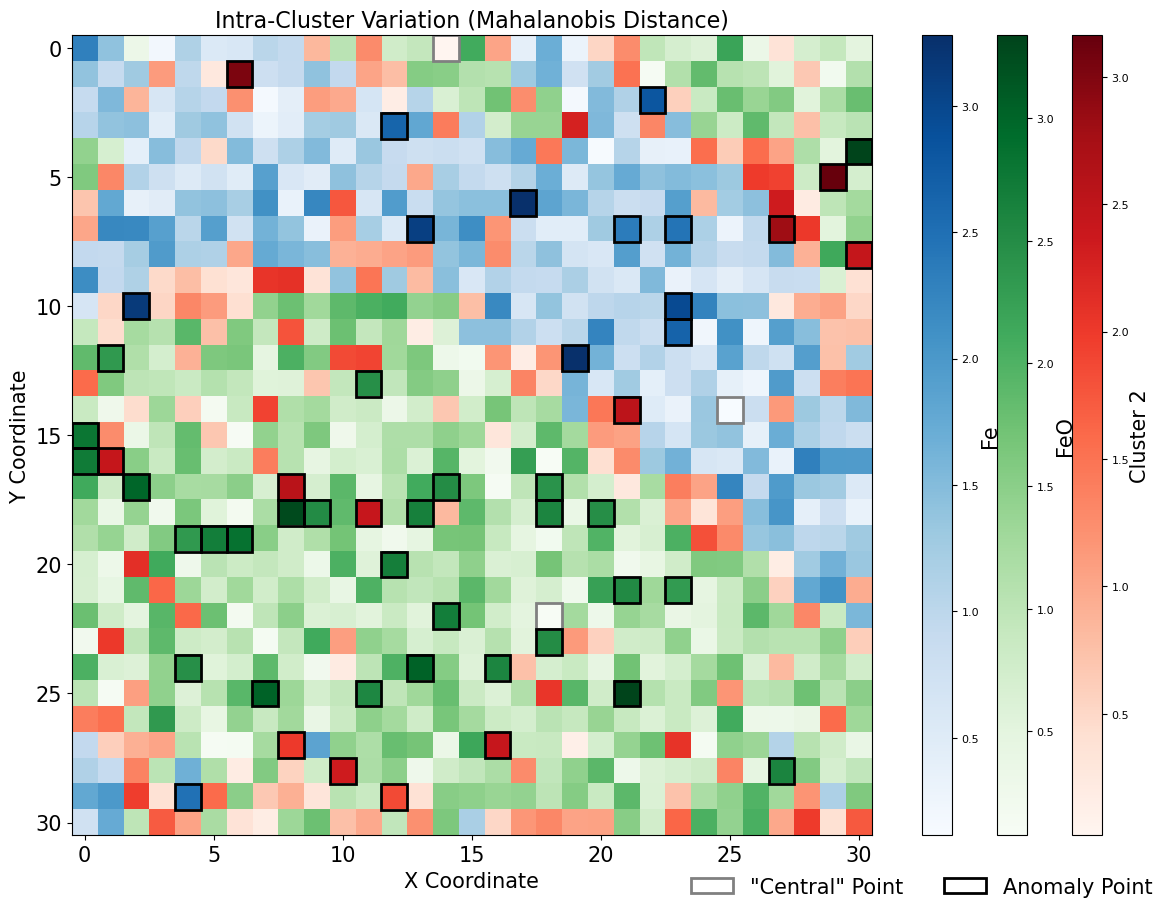

In [75]:
plot_intra_cluster_variation_map(loc_relative, variations_c4, cluster_labels_cnmf4, (31,31), None, cluster_name_map, anomalies_cluster_cnmf_coords4)

- 3 clusters for weights show the boundary quite well


In [76]:
anomalies_scores, anomalies_coords = detect_anomalies_cnmf(weights, coor_dict, loc)

weights for reference 1 are: 
 [[0.7832683  0.25548655]
 [0.8244632  0.2174768 ]
 [0.7656051  0.20121911]
 [0.77096283 0.25219312]
 [0.78766346 0.21282928]
 [0.9068269  0.05847082]
 [0.7611296  0.22893563]
 [0.7409109  0.28291225]
 [0.43118754 0.55152315]]
weights for reference 2 are: 
 [[0.27934024 0.7261028 ]
 [0.28458908 0.6411542 ]
 [0.48369157 0.47772655]
 [0.1373809  0.9162525 ]
 [0.29949474 0.66364706]
 [0.5072918  0.44343898]
 [0.30324557 0.7076615 ]
 [0.19640668 0.64813775]
 [0.48080176 0.47104073]]


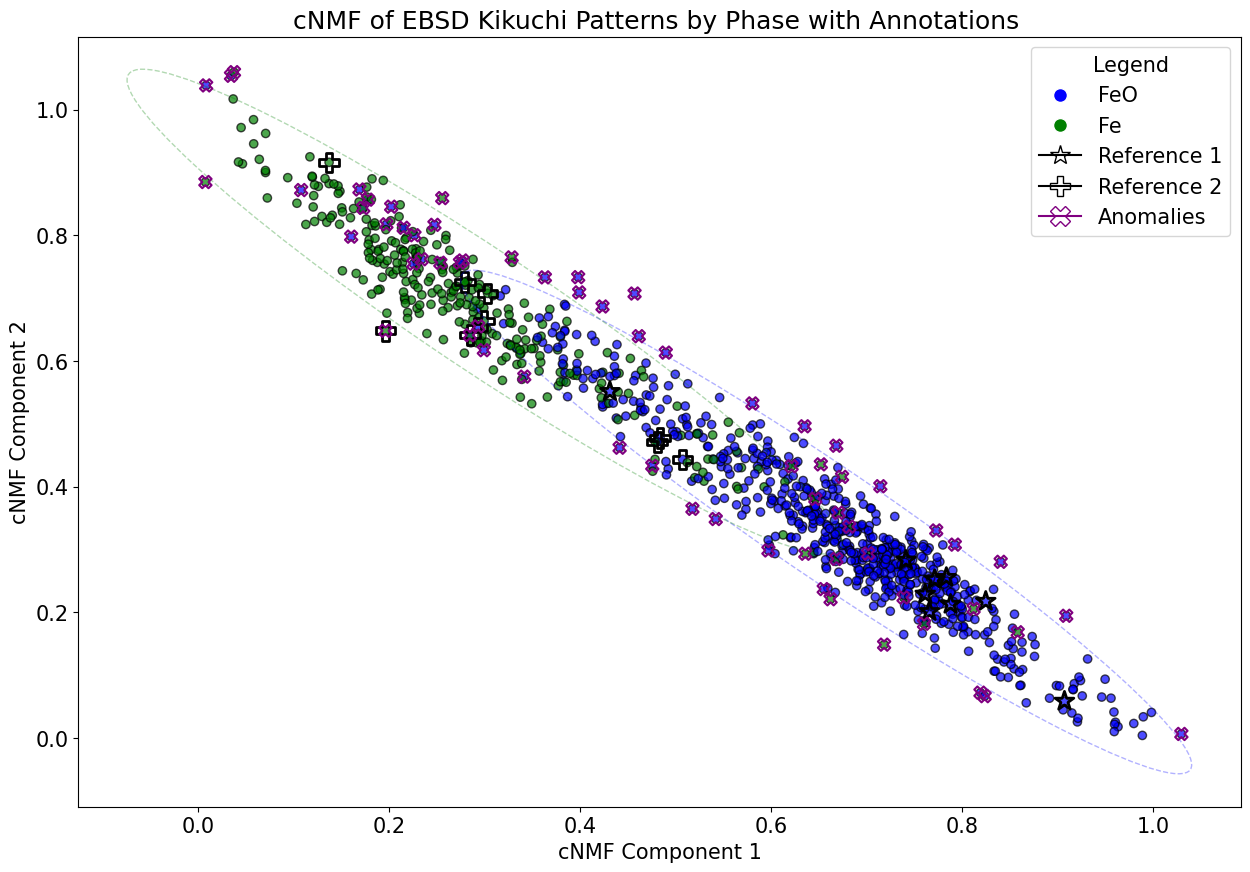

In [77]:
# _plot_cnmf(weights, coor_dict, loc)
_plot_cnmf(weights, coor_dict, loc, ref1_pos, ref2_pos, anomalies_scores)

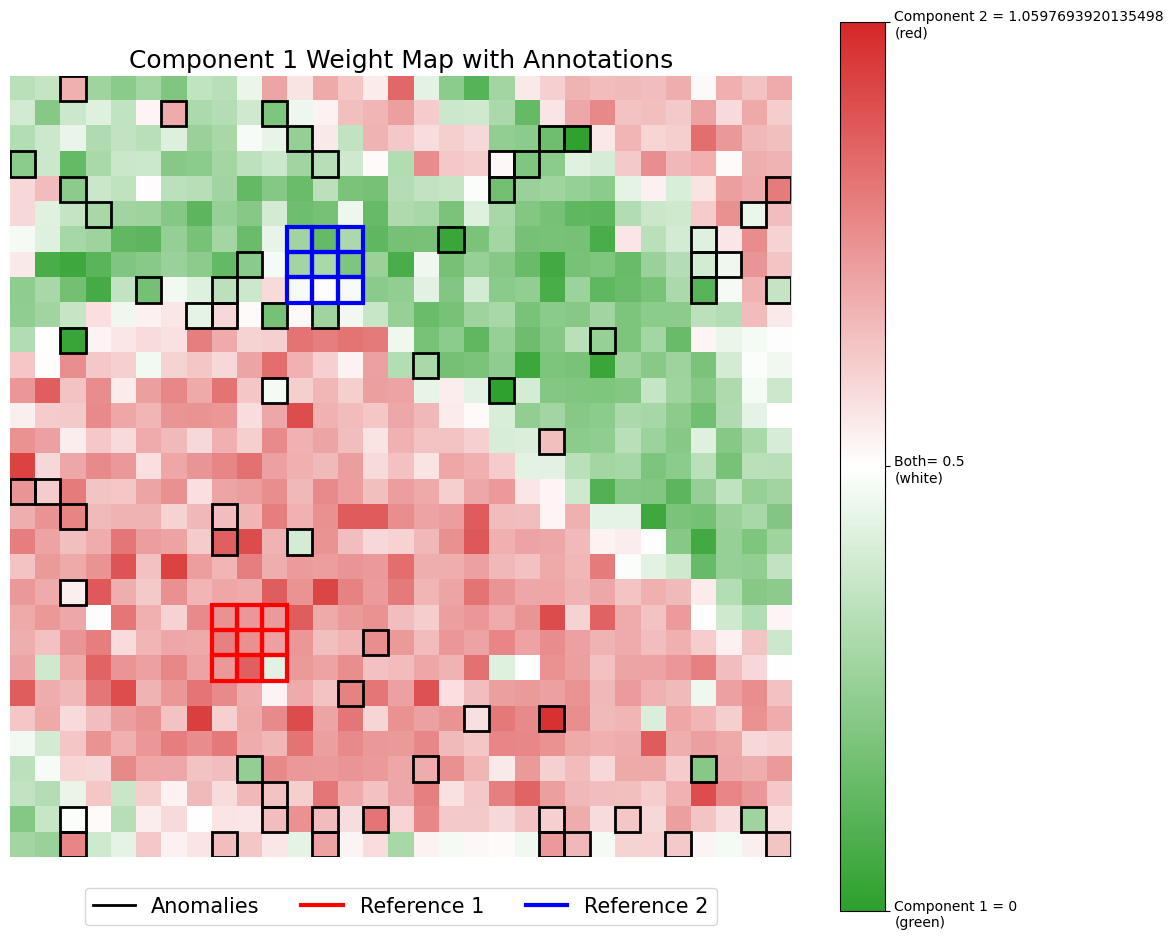

In [78]:
plot_weight_map_cnmf(weights, loc, anomalies_coords, ref1_pos, ref2_pos, 0)

### 1.3 EDS combined? （only content of elements）

### 1.3.1 cNMF

In [79]:
# stacked the pixel values with element values
eds_r1 = get_eds_average(x_range_1,y_range_1,s_edax)
eds_r2 = get_eds_average(x_range_2,y_range_2,s_edax)

eds_r1 = normalize_sum(eds_r1)
eds_r2 = normalize_sum(eds_r2)
eds = np.stack((eds_r1, eds_r2))

eds_mixed = np.hstack((components,eds))

In [80]:
weights,mse,r_square = run_cNMF_mixeds(R6, eds_mixed, loc, s_edax)

[                                        ] | 0% Completed | 1.53 ms

[########################################] | 100% Completed | 110.16 ms
[########################################] | 100% Completed | 108.13 ms
[########################################] | 100% Completed | 105.73 ms
[########################################] | 100% Completed | 109.51 ms
[########################################] | 100% Completed | 105.76 ms
[########################################] | 100% Completed | 107.49 ms
[########################################] | 100% Completed | 106.96 ms
[########################################] | 100% Completed | 107.45 ms
[########################################] | 100% Completed | 115.37 ms
[########################################] | 100% Completed | 131.07 ms
[########################################] | 100% Completed | 124.44 ms
[########################################] | 100% Completed | 122.59 ms
[########################################] | 100% Completed | 115.44 ms
[########################################] | 100% Completed | 11

Optimal clustering number: 2, silhouette: 0.638


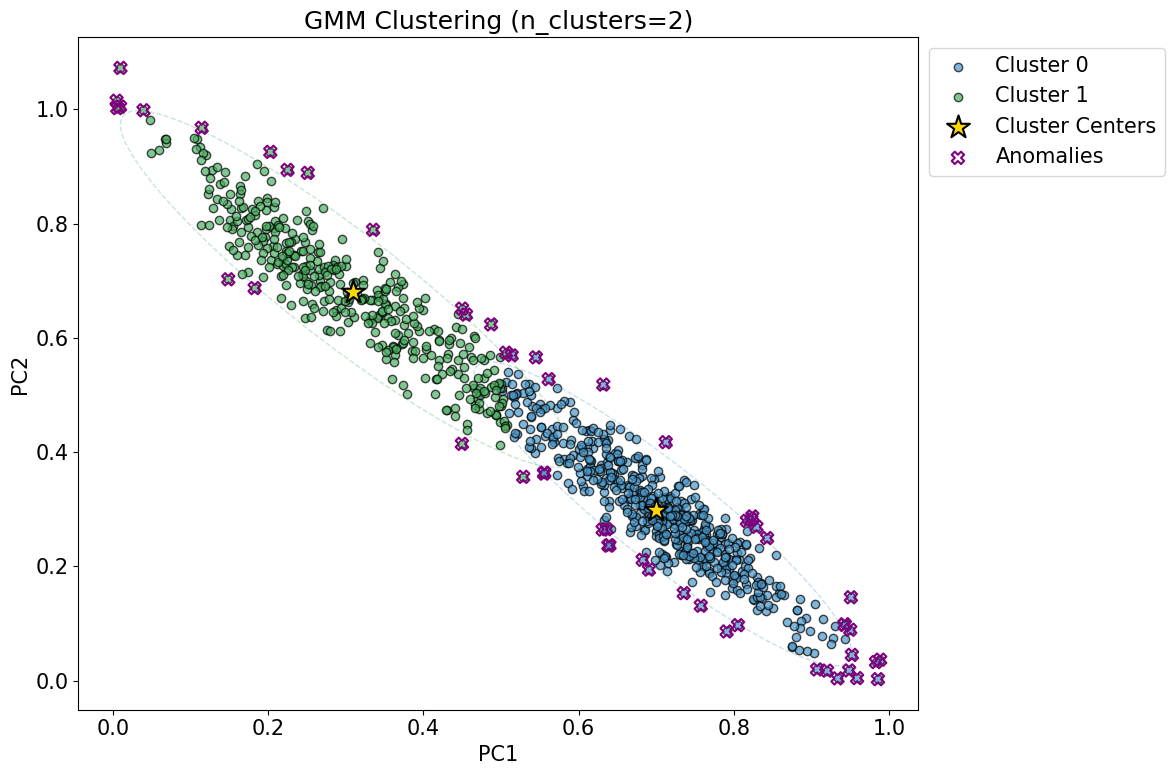

In [82]:
gmm_model7, cluster_coords_cnmf5, cluster_labels_cnmf5, optimal_n, silhouette = gmm_clustering(weights, loc_relative, None, 10)
print(f"Optimal clustering number: {optimal_n}, silhouette: {silhouette:.3f}")
coord_to_label_cnmf5 = {}
for label, coords_list in cluster_coords_cnmf5.items():
    for coord in coords_list:
        coord_tuple = tuple(coord)
        coord_to_label_cnmf5[coord_tuple] = label
anomalies_cluster_cnmf_weights5, anomalies_cluster_cnmf_coords5 = detect_anomalies_cnmf(weights, coord_to_label_cnmf5, loc_relative)
centers_c5, covs_c5, variations_c5 = calculate_cluster_metrics(gmm_model7, cluster_labels_cnmf5, weights)

plot_gmm_clusters(weights, cluster_labels_cnmf5, optimal_n, variations_c5, 2, anomalies_cluster_cnmf_weights5)

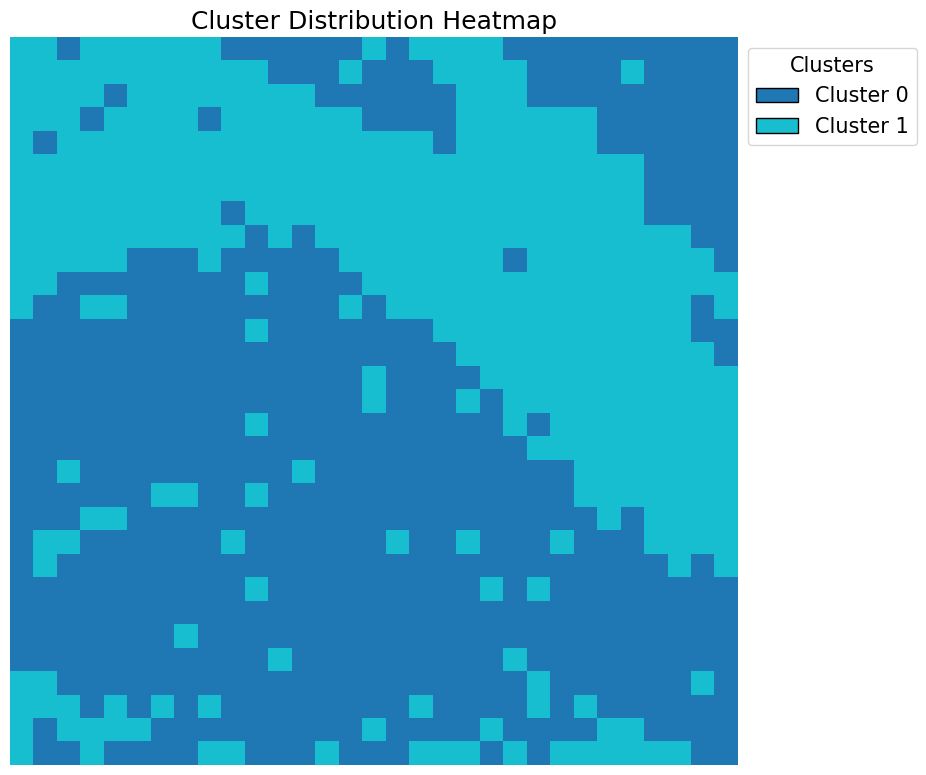

Clustering accuracy: 0.836


In [84]:
plot_cluster_heatmap(cluster_coords_cnmf5,(31,31))

cluster_name_map = {
    0: 'FeO',
    1: 'Fe'
}
name_map = {
    1: 'Fe3O4',
    2: 'FeO',
    3: 'Fe'
}
match_results, acc = clustering_accuracy(coor_dict_roi, coord_to_label_cnmf5, name_map, cluster_name_map)
print(f"Clustering accuracy: {acc:.3f}")

Cluster centers and corresponding labels: [(17, 18, 0)]
Cluster centers and corresponding labels: [(17, 18, 0), (3, 2, 1)]


d:\Material Files\PhD\kikuchi_cnmf\kikuchi-cnmf\micro_segmentation\cluster_analysis.py:323: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


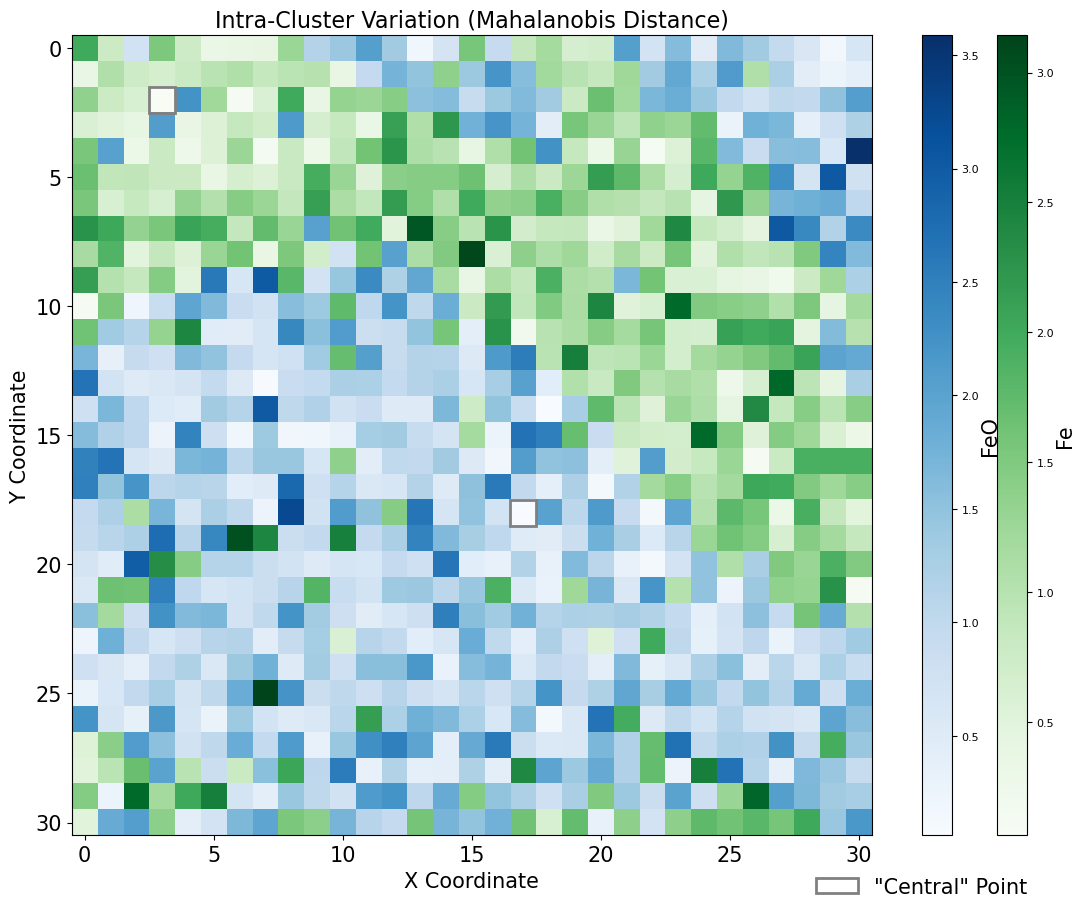

In [87]:
cluster_name_map = {
    0: 'FeO',
    1: 'Fe',
}
plot_intra_cluster_variation_map(loc_relative, variations_c5, cluster_labels_cnmf5, (31,31), None, cluster_name_map, None)

In [88]:
anomalies_scores, anomalies_coords = detect_anomalies_cnmf(weights, coor_dict, loc)

weights for reference 1 are: 
 [[0.7318243  0.31410918]
 [0.9309766  0.09526236]
 [0.7600626  0.2075743 ]
 [0.40150672 0.6705444 ]
 [0.84300697 0.14939262]
 [0.8300585  0.14686531]
 [0.79004294 0.19582209]
 [0.7788667  0.2395043 ]
 [0.37993148 0.6092206 ]]
weights for reference 2 are: 
 [[0.22175035 0.7919003 ]
 [0.43085763 0.47416842]
 [0.494097   0.4658754 ]
 [0.10879182 0.9487363 ]
 [0.25955987 0.709133  ]
 [0.5388575  0.40734476]
 [0.16349046 0.8668445 ]
 [0.14853053 0.7026317 ]
 [0.42349607 0.53656995]]


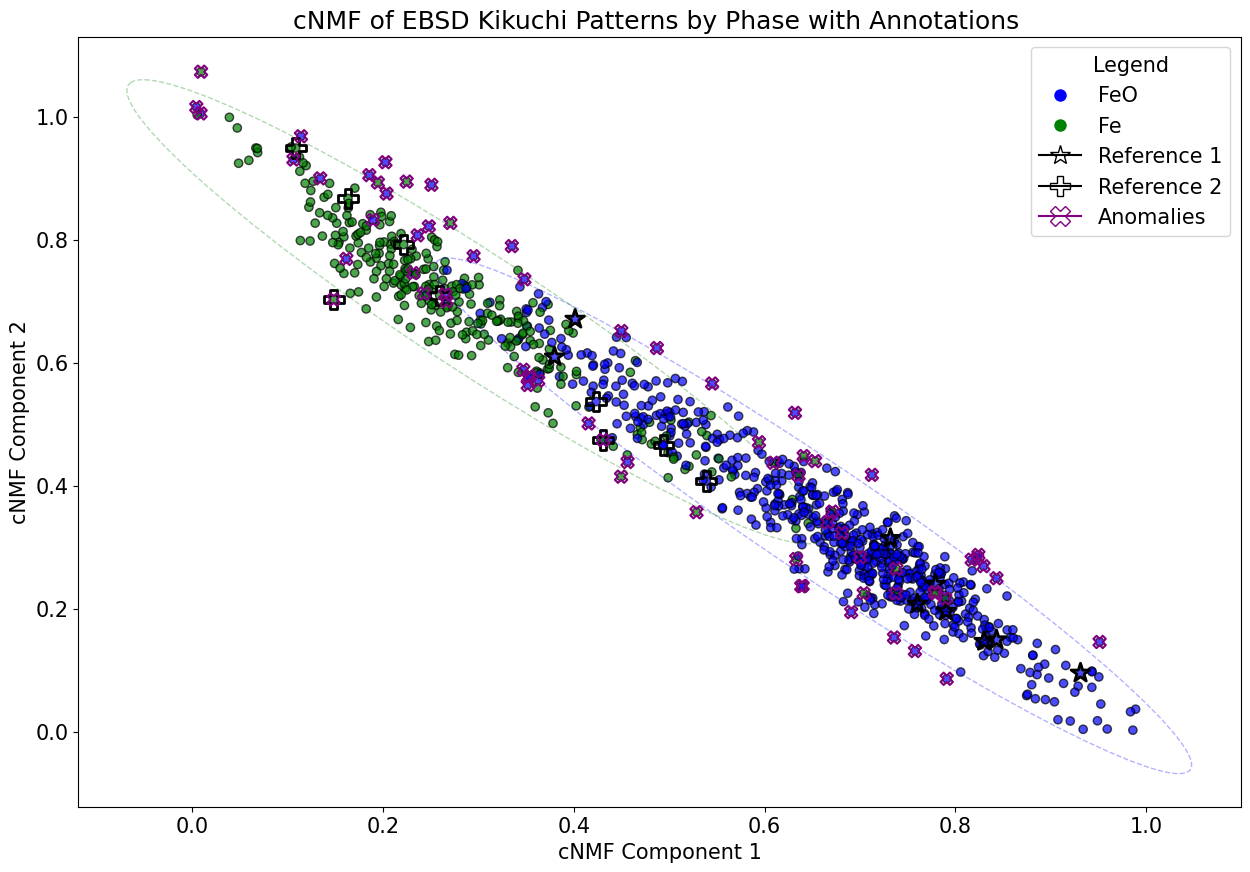

In [89]:
_plot_cnmf(weights, coor_dict, loc, ref1_pos, ref2_pos, anomalies_scores)

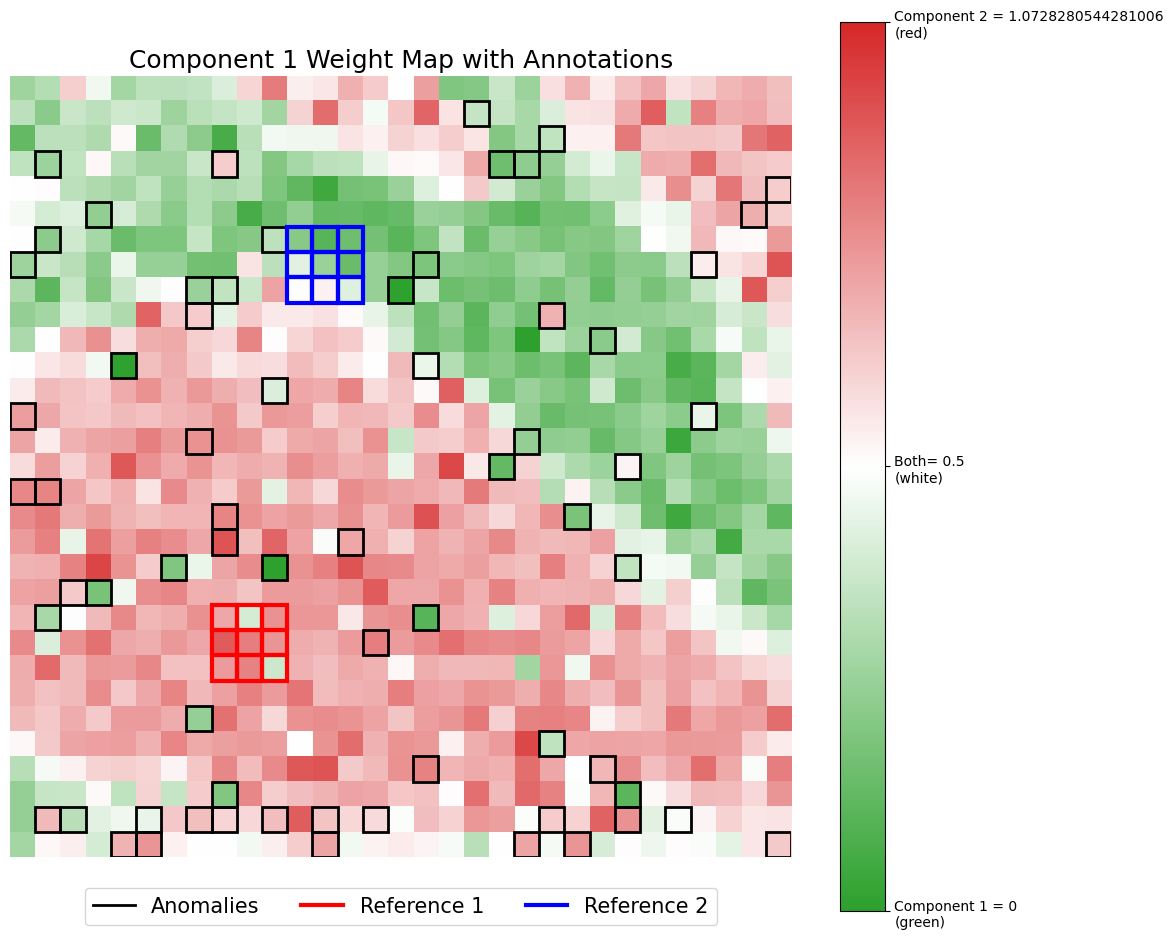

In [90]:
plot_weight_map_cnmf(weights, loc, anomalies_coords, ref1_pos, ref2_pos, 0)

> ### Some Thinking about what else information we can obtain from just kikuchi? (diffraction of crystalline planes)
- Standard EBSD
    1. Phase identification
    2. crystal orientation
    3. misorientation/ grain boundaries
    4. Defects/ Strain and Stress/ Dislocation(subtle shifts of kikuchi bands)/ Local lattice or composition change ---HR-EBSD


- Solutions
    1. DR/ Latent space representation/ Clustering - Phase (Now) + (to do)Misorientation (Minor)
    2. 
    3. 
    